In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8

# <p style="text-align: center;"> Charter school identities project:<br/> Analyzing Word Embedding Models with word2vec
<p style="text-align: center;">Creator: Jaren Haber, PhD Candidate<br/>Institution: Department of Sociology, University of California, Berkeley<br/>Date created: July 20, 2018

## Initialize Python

In [2]:
# IMPORTING KEY PACKAGES
'''
import csv # for reading in CSVs and turning them into dictionaries
import re # for regular expressions
import os # for navigating file trees
import nltk # for natural language processing tools
import pandas as pd # for working with dataframes
import numpy as np # for working with numbers
import pickle # For working with .pkl files
from tqdm import tqdm # Shows progress over iterations, including in pandas via "progress_apply"
from ast import literal_eval
'''
import gensim # for word embedding models
import _pickle as cPickle # Optimized version of pickle
import gc # For managing garbage collector

In [3]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # approximate but effective (and common) method of normalizing words: stems words by implementing a hierarchy of linguistic rules that transform or cut off word endings
'''
from nltk.corpus import stopwords # for eliminating stop words
stopenglish = list(stopwords.words("english")) # assign list of english stopwords
import string # for one method of eliminating punctuation
punctuations = list(string.punctuation) # assign list of common punctuation symbols
punctuations+=['•','©','–'] # Add a few more punctuations also common in web text
import hashlib # For checking for duplicate long strings with minimal memory drain
'''

'\nfrom nltk.corpus import stopwords # for eliminating stop words\nstopenglish = list(stopwords.words("english")) # assign list of english stopwords\nimport string # for one method of eliminating punctuation\npunctuations = list(string.punctuation) # assign list of common punctuation symbols\npunctuations+=[\'•\',\'©\',\'–\'] # Add a few more punctuations also common in web text\nimport hashlib # For checking for duplicate long strings with minimal memory drain\n'

In [4]:
stemmer = PorterStemmer # Makes stemming more accessible
stem = stemmer().stem 
stem("philosophy")

'philosophi'

In [5]:
# FOR ANALYZING THE TEXT
'''
from sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially
countvec = CountVectorizer(tokenizer=nltk.word_tokenize)
from sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs
tfidfvec = TfidfVectorizer()
from sklearn.decomposition import LatentDirichletAllocation # for topic modeling

from scipy.spatial.distance import cosine # for cosine similarity
from sklearn.metrics import pairwise # for pairwise similarity
from sklearn.manifold import MDS, TSNE # for multi-dimensional scaling

import Cython # For parallelizing word2vec
'''

'\nfrom sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially\ncountvec = CountVectorizer(tokenizer=nltk.word_tokenize)\nfrom sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs\ntfidfvec = TfidfVectorizer()\nfrom sklearn.decomposition import LatentDirichletAllocation # for topic modeling\n\nfrom scipy.spatial.distance import cosine # for cosine similarity\nfrom sklearn.metrics import pairwise # for pairwise similarity\nfrom sklearn.manifold import MDS, TSNE # for multi-dimensional scaling\n\nimport Cython # For parallelizing word2vec\n'

In [6]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns # To make matplotlib prettier
sns.set(style='white')
sns.despine()

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['stem']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
# Define data and model file paths
charters_path = "../../nowdata/traincf_2015_15_250_counts.pkl" # All text data; only charter schools (regardless if open or not)
wordsent_path = "../data/wem_wordsent_data_train250_nostem.pkl"
phrasesent_path = "../data/wem_phrasesent_data_train250_nostem.pkl"
wem_path = "../data/wem_model_train250_nostem.txt"
wem_newpath = "../data/wem_model_train250_nostem_new_8700.txt"

# Define file paths to existing dicts
ess_path = "../dicts/ess_dict.txt"
prog_path = "../dicts/prog_dict.txt"
rit_path = "../dicts/rit_dict.txt"

# Define file paths for new dicts
ess_valid = "../dicts/ess_valid.txt"
prog_valid = "../dicts/prog_valid.txt"
rit_valid = "../dicts/rit_valid.txt"
ess_polar = "../dicts/ess_polar.txt"
prog_polar = "../dicts/prog_polar.txt"
rit_polar = "../dicts/rit_polar.txt"

## Define helper functions

In [8]:
def quickpickle_load(picklepath, outputvar):
    '''Very time-efficient way to load pickle-formatted objects into Python.
    Uses C-based pickle (cPickle) and gc workarounds to facilitate speed. 
    Input: Filepath to pickled (*.pkl) object.
    Output: Python object (probably a list of sentences or something similar).'''

    output = open(picklepath, 'rb')
    gc.disable() # disable garbage collector

    outputvar = cPickle.load(output)

    gc.enable() # enable garbage collector again
    output.close()
    
    return outputvar

In [293]:
def write_list(file_path, textlist):
    """Writes textlist to file_path. Useful for recording output of parse_school()."""
    
    with open(file_path, 'w') as file_handler:
        for elem in textlist:
            file_handler.write("{}\n".format(elem))
        return    

In [10]:
def load_list(file_path):
    """Loads list into memory. Must be assigned to object."""
    
    textlist = []
    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            textlist.append(line)
            line = file_handler.readline()
    return textlist

In [11]:
def load_dict(custom_dict, file_path):
    """
    Loads in a dictionary from a file.
    Each word is stemmed and lower-cased in preparation for matching with word2vec.
    Adds each entry from the dict at file_path to the defined set custom_dict (the input), 
    which can also be an existing dictionary. This allows the creation of combined dictionaries!
    Multi-word dictionary elements (phrases) are transformed into a single word by
    replacing spaces with underscores, e.g. "college oriented" -> "college_oriented".
    """

    with open(file_path) as file_handler:
        line = file_handler.readline()
        while line:
            line = line.replace("\n", "") # Replace newlines at start, to avoid confusing tokenizers
            linetoks = word_tokenize(line)
            
            if len(linetoks) > 1: # For phrases (>1 word long) in dictionary
                line = [PorterStemmer().stem(word.lower()) for word in linetoks]
                line = "_".join(word for word in line)
                custom_dict.add(line.replace("_","")) # Also add element with no space between words
            else:
                line = PorterStemmer().stem(line.lower()) # For single-word dict elements, just stem it
            
            if "-" in line:
                custom_dict.add(line.replace("-","_")) # If appropriate, also add element that replaces "-" with "_"
                custom_dict.add(line.replace("-","")) # Also add element with no space between words
            
            custom_dict.add(line) # Add line after stemming dictionary entries and eliminating newlines
            line = file_handler.readline() # Look for anything else in that line, add that too
            
    return custom_dict

In [12]:
ess_dict, prog_dict, rit_dict = set(), set(), set()

ess_dict = load_dict(ess_dict, ess_path)
prog_dict = load_dict(prog_dict, prog_path)
rit_dict = load_dict(rit_dict, rit_path)

In [13]:
def make_dicts(paths_list):
    '''Create ideology dictionaries: essentialism, progressivism, and ritualism.
    Input: List of paths to all files holding dictionaries.
    Output: List of dictionaries, each of which is a list of terms.'''
    
    keydicts = [] # Initialize list holding all dicts
    
    for path in paths_list:
        thisdict = set() # Initialize variable holding terms
        thisdict = load_dict(thisdict, path) # Load from file into variable
        keydicts.append(thisdict) # Add dict to list of dicts
    
    #ess_dict, prog_dict, rit_dict, all_ideol, all_dicts = set(), set(), set(), set(), set()

    #all_ideol = load_dict(all_ideol, ess_path)
    #all_ideol = load_dict(all_ideol, prog_path) # For complete ideological list, append second ideological dict
    #all_dicts = load_dict(all_ideol, rit_path) # For complete dict list, append ritual dict terms too

    #ess_dict = load_dict(ess_dict, ess_path)
    #prog_dict = load_dict(prog_dict, prog_path)
    #rit_dict = load_dict(rit_dict, rit_path)
    
    #keydicts = [ess_dict, prog_dict, rit_dict]
    
    print("Lists of key terms (dictionaries) loaded!")
    
    return(keydicts)

In [14]:
def dict_cohere(thisdict, wem_model):
    '''Computes the average cosine similarity score of dictionary terms with each other, 
    ...one day (not yet) to be compared to the average cosine similarity score between all terms 
    in thisdict and the total model vocabulary. 
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word with all other words in the list of key terms.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dict_avg_dist = 0
    all_avg_dists = 0
    model_avg_dists = 0
    
    # Compute average cosine similarity score of each word with other dict words:
    for word in thisdict:
        word_avg_dist = (wem_model.distances(word, other_words=thisdict).sum())/len(thisdict)
        word_avg_dists += word_avg_dist
    dict_avg_dist = 1 - word_avg_dists/len(thisdict) # Find average cosine similarity score by subtracting avg. distance from 1

    # For comparison, compute average cosine similarity score of each word with ALL other words in the model vocabulary:
    #for word in thisdict:
    #    all_avg_dist = (wem_model.distances(word).sum())/len(model.vocab) # Default is to compare each word with all words
    #    all_avg_dists += all_avg_dist
    #model_avg_dist = 1 - all_avg_dists/len(model.vocab) # Find average cosine similarity score by subtracting avg. distance from 1

    #print("Average cosine similarities by word for this dictionary:       \t" + str(dict_avg_dist))
    #print("Compare to avg. cosine similarities by dict words to ALL words:\t" + str(model_avg_dist))
    
    return dict_avg_dist

In [15]:
def clean_textlist(textlist):
    """Removes extraneous spaces: at beginning and end of word2vec-format list of strings, 
    and between two parts of word at start of each line.
    
    Input: list of strings in word2vec format, e.g. ["aardvark .40 .01 .21...\n", "banana .25 .71 .06...\n", ...].
    Output: cleaned list of strings in word2vec format, which ideally should work for word2vec model generation."""
    
    unspaced_text = [textlist[0].replace("\n", "")]

    for oneline in textlist[1:]:
        first, pieces, line = "", [], []
        
        if "\\" in oneline:
            continue # Skip lines with URLs, etc.
        
        for piece in oneline.strip(" ").split(" "): # Remove spaces from beginning and end, then split by spaces
            if piece in ["", " ", "1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10."]:  # ["", " "] or (piece.replace(".", "").isdigit() and literal_eval(piece) >= 1):
                continue # Omit empty or erroneous elements (1.0 or greater)
            elif not piece.replace("-", "").strip("\n").replace(".", "").replace("e", "").isdigit(): # Check if digit (after removing negative signs, decimal points, scientific notation, and newlines)
                first += piece # If not a digit, it's part of the word, so concatenate it with rest of word
            else:
                pieces.append(piece.replace("\n", "")) # If a digit, add it to list of digits in vector

        line = (first + " " + " ".join([piece for piece in pieces])).strip(" ") # Reconstruct vector
        unspaced_text.append(line) # Add to new word2vec text list/ object
    
    return unspaced_text

## Refine & Validate the Dictionaries

In [16]:
# Clear out from file any lines with words containing "\\":
#import fileinput
#for line in fileinput.input(wem_path, inplace=True):
#    if "\\" in line:
#        continue
#    print(line, end='')

In [17]:
#wemtext = load_list(wem_path)
#wemtext = clean_textlist(wemtext) # Remove problematic spacing, clean
#wemtext[:10]

In [18]:
#n = 129217
#print(len(word_tokenize(wemtext[n])), "\nfor this vector, VS. length of next vector:\n", len(word_tokenize(wemtext[n+1])))
#wemtext[n]

In [19]:
model = gensim.models.KeyedVectors.load_word2vec_format(wem_newpath) # Load word2vec model

In [20]:
# dictionary of words in model (may not work for old gensim)
print(len(model.vocab))
sorted(list(model.vocab))

417813


['\x00',
 '\x00\x00',
 '\x00\x00\x00',
 '\x00\x00\x00\x00',
 '\x00\x00\x00\x00\x00',
 '\x00\x00\x00\x00\x00\x00',
 '\x00\x00\x00\x00\x00\x00\x00\x00',
 '\x00\x00\x00\x00\x00\x00\x00ا',
 '\x00\x00\x00\x00\x00\x00_\x00\x00',
 '\x00\x00\x00\x00\x00\x00_\x00\x00\x00\x00\x00ا',
 '\x00\x00\x00\x00\x00\x00_\x00\x00\x00\x00ا',
 '\x00\x00\x00\x00\x00\x00_ء\x00\x00\x00\x00\x00ا',
 '\x00\x00\x00\x00\x00\x00_ء\x00\x00\x00ر\x00ا',
 '\x00\x00\x00\x00\x00\x00_سر\x00\x00',
 '\x00\x00\x00\x00\x00\x00أ_ت\x00\x00\x00\x00\x00',
 '\x00\x00\x00\x00\x00\x00ا',
 '\x00\x00\x00\x00\x00\x00ا_\x00\x00\x00',
 '\x00\x00\x00\x00\x00\x00او',
 '\x00\x00\x00\x00\x00_\x00\x00',
 '\x00\x00\x00\x00\x00_\x00\x00\x00\x00',
 '\x00\x00\x00\x00\x00_\x00\x00\x00\x00\x00',
 '\x00\x00\x00\x00\x00_\x00\x00ر\x00\x00\x00ا',
 '\x00\x00\x00\x00\x00أ',
 '\x00\x00\x00\x00\x00أ_\x00\x00\x00\x00\x00ا',
 '\x00\x00\x00\x00\x00ا',
 '\x00\x00\x00\x00\x00ا_\x00\x00',
 '\x00\x00\x00\x00\x00ا_\x00\x00\x00',
 '\x00\x00\x00\x00\x00د_\x00\x00\x00\x

### Fine-tuning existing INQUIRY dicts

In [24]:
inquiry_fin = [elem.strip('\n') for elem in load_list('../dicts/inquiry.txt')]
inquiry_fin

['abilities',
 'academically-integrated',
 'acquire_requisite',
 'active_participation',
 'active_playful',
 'activities',
 'activities/lessons',
 'activity-project-problem-based',
 'activity/project',
 'additional_playtime',
 'adept_at_facilitating',
 'adherents',
 'admittedly_fallible',
 'affinity_enthusiasm',
 'agile_and_thrives',
 'aligned_to_the_ngss',
 'allegiances',
 'altered/added',
 'approaches_such_as_sheltered',
 'arguments_and_informative/explanatory',
 'arithmetic_reasoning',
 'art-filled',
 'atomic_nucleus',
 'awaken_the_imagination',
 'awareness_and_phonics',
 'bearing_on_the_viability',
 'become_self-disciplined',
 'benefits_of_co-op',
 'big-picture_understanding',
 'bilingual_eng./span',
 'biotechnology_and_genetics',
 'brain-friendly',
 'break/gross_motor',
 'bricks4kidz',
 'brighter_tomorrow',
 'brilliantly_infused',
 'calming_breaths',
 'capitalism_and_socialism',
 'career-focused_and_technical',
 'carefully_weigh',
 'case-based',
 'cause_of_genuine',
 'challenging_

In [37]:
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        print("NOT FOUND, REMOVING:\t" + word)
    else:
        print("FOUND, KEEPING:\t\t" + word)
        pass

FOUND, KEEPING:		abilities
FOUND, KEEPING:		academically-integrated
FOUND, KEEPING:		acquire_requisite
FOUND, KEEPING:		activities
FOUND, KEEPING:		activities/lessons
FOUND, KEEPING:		activity-project-problem-based
FOUND, KEEPING:		activity/project
FOUND, KEEPING:		adept_at_facilitating
FOUND, KEEPING:		adherents
FOUND, KEEPING:		admittedly_fallible
FOUND, KEEPING:		affinity_enthusiasm
FOUND, KEEPING:		agile_and_thrives
FOUND, KEEPING:		aligned_to_the_ngss
FOUND, KEEPING:		allegiances
FOUND, KEEPING:		altered/added
FOUND, KEEPING:		approaches_such_as_sheltered
FOUND, KEEPING:		arguments_and_informative/explanatory
FOUND, KEEPING:		arithmetic_reasoning
FOUND, KEEPING:		art-filled
FOUND, KEEPING:		atomic_nucleus
FOUND, KEEPING:		awaken_the_imagination
FOUND, KEEPING:		bearing_on_the_viability
FOUND, KEEPING:		benefits_of_co-op
FOUND, KEEPING:		bilingual_eng./span
FOUND, KEEPING:		biotechnology_and_genetics
FOUND, KEEPING:		brain-friendly
FOUND, KEEPING:		break/gross_motor
FOUND, KEEPING:

FOUND, KEEPING:		myon_reader
FOUND, KEEPING:		mythological_creature
FOUND, KEEPING:		natural
FOUND, KEEPING:		nature-based_perspective
FOUND, KEEPING:		nature_journaling
FOUND, KEEPING:		navigable
FOUND, KEEPING:		near-daily_basis
FOUND, KEEPING:		need-to-know_facts
FOUND, KEEPING:		needing_improvement
FOUND, KEEPING:		negotiating_these_aspects
FOUND, KEEPING:		neuro-anatomy
FOUND, KEEPING:		next_generation
FOUND, KEEPING:		non-arts_objectives
FOUND, KEEPING:		non-coercive
FOUND, KEEPING:		non-dominant
FOUND, KEEPING:		non-instrumental
FOUND, KEEPING:		non-montessori_classrooms
FOUND, KEEPING:		noninfectious
FOUND, KEEPING:		nonpolitical
FOUND, KEEPING:		novel-based
FOUND, KEEPING:		nurtures_mutual
FOUND, KEEPING:		nurturing
FOUND, KEEPING:		nurturing_tight-knit
FOUND, KEEPING:		observation_and_experimentation
FOUND, KEEPING:		orientating
FOUND, KEEPING:		originated_in_cuba
FOUND, KEEPING:		outcome-focused
FOUND, KEEPING:		pace_most_suited
FOUND, KEEPING:		parabolas_graphed
FOUND, KEEP

In [523]:
inquiry_fin = ['abilities_will_be_maximized',
               'abilities',
               'ability-grouped',
               'academically-integrated',
               'acquire_requisite',
               'active_inquiry',
               'activities',
               'activities/lessons',
               'activity/project',
               'adept_at_facilitating',
               'adherents',
               'adjusted_and_thrived',
               'admittedly_fallible',
               'affinity_enthusiasm',
               'agile',
               'aligned_to_the_ngss',
               'allegiances',
               'altered/added',
               'amazed_by_the_generosity',
               'anecdotes',
               'appealing_and_relevant',
               'approaches_such_as_sheltered',
               'appropriately_allocated',
               'architecture',
               'arguments_and_informative/explanatory',
               'arithmetic_reasoning',
               'art-filled',
               'artistic',
               'assemble_the_pieces',
               'atomic_nucleus',
               'awaken_the_imagination',
               'bearing_on_the_viability',
               'benefits_of_co-op',
               'bi-literacy',
               'biotechnology_and_genetics',
               'brain-compatible',
               'brain-friendly',
               'break/gross_motor',
               'bricks4kidz',
               'brighter_tomorrow',
               'brilliantly_infused',
               'brochure_to_solidify',
               'c++_programming',
               'calming_breaths',
               'cameras',
               'capitalism_and_socialism',
               'career-focused_and_technical',
               'carefully_weigh',
               'case-based',
               'championing_issues',
               'channels_their_energies',
               'character-based_strengths',
               'checking-for-understanding',
               'child-centered_individualized',
               'child-centered',
               'child-sized_furniture',
               'choir_ensemble',
               'circles_graphed',
               'circulatory_and_nervous',
               'city-planning',
               'civically_active',
               'classical/stem_based',
               'climate_improvement/improvement',
               'coaches/leaders',
               'cogent',
               'cognitively_demanding',
               'coherent_sequenced',
               'cohesiveness',
               'collaborate_on_a_large-scale',
               'collaborative_student-community',
               'college-level_options',
               'colorism',
               'comma_rules',
               'commensurate_with_their_abilities',
               'committing_offenses',
               'commonly_confused',
               'communication/collaboration',
               'community-wide',
               'comparing_the_inputs',
               'compelling_paragraphs',
               'competency_and_mastery',
               'complex_adult-world',
               'complexity',
               'comprehensibility',
               'comprehensive_16-hour',
               'conceiving',
               'concept/skill',
               'concierge_medicine',
               'concurrently_with_the_choreography',
               'considering_waldorf',
               'constructivism',
               'constructivist-based',
               'constructivist',
               'consultation/collaboration',
               'content-rich_nonfiction',
               'content-specific',
               'context',
               'continous',
               'continuity_and_commitment',
               'core-content_courses',
               'craftsmanship',
               'create_spectacles',
               'creative',
               'creativity',
               'critical-thinkers',
               'critical-thinking',
               'cross-content',
               'crystallization',
               'cultural_diversities',
               'cultural_heritages',
               'curiosity',
               'curriculum/standards',
               'data-rich',
               'decision-making',
               'decisionmaking_skills',
               'deepen',
               'deeper',
               'definiteness',
               'demanding_college-preparatory',
               'derivations',
               'describe_distributions',
               'design2fab_lab',
               'develop/implement',
               'developing',
               'dialoguing',
               'diaries_and_journals',
               'different/',
               'differentiated/personalized',
               'differing_structure',
               'discerning_listeners',
               'discover',
               'discovery-based',
               'disempower',
               'disparate_personalities',
               'dissection_techniques',
               'dissipate',
               'distraction-free',
               'drafting_and_revising',
               'drove_the_expedition',
               'dynamic_collaboration',
               'dynamically_and_immediately',
               'edifying',
               'editing_and_proofing',
               'effectiveness_of_metacognitive',
               'effects_of_repetition',
               'efficacy_by_encouraging',
               'eliminating_unnecessary',
               'elitism',
               'ellipsis_points',
               'embraced_and_supported',
               'emojis',
               'encourage',
               'encouraging',
               'enduring_conceptual',
               'enduring_relationships',
               'engaged_citizen',
               'engaging',
               'enlargement',
               'ennoble',
               'ennobling_effect',
               'environment',
               'equipping_educators',
               'esl/family',
               'et.al.',
               'evaluate_the_motives',
               'evidence_in_a_nuanced',
               'examples_evoke',
               'excellence_through_ingenuity',
               'expeditions',
               'experience-based',
               'experiental_learning',
               'experiential_approach',
               'experiential',
               'experientially',
               'experimental_labs',
               'experimentation',
               'exploration',
               'explorations', 
               'explorative',
               'expose_them_to_a_wider',
               'exposed_to_a_coherent',
               'facilitation_techniques',
               'faint_of_heart',
               'feedback',
               'field-based',
               'fieldwork',
               'filming',
               'fiscal_mismanagement',
               'force_to_be_reckoned',
               'fostered',
               'fostering',
               'fuels_my_desire',
               'fully-vetted',
               'functional_weakness',
               'gender-nonconforming',
               'generalizations_and_predictions',
               'gets_maximized',
               'goal-driven',
               'gods_of_asgard',
               'grade-by-grade_year-by-year',
               'gradual_manner',
               'grander_scale',
               'grapple_with_difficult',
               'greek_philosophers',
               'grit_and_zest',
               'growth',
               'hand-on',
               'hands-on_and_minds-on',
               'hands-on_learning',
               'hands-on_minds-on',
               'hands-on/minds-on',
               'hands‑on',
               'harmonize',
               'headmaster_letters',
               'health/life_management',
               'helps',
               'higher-level_cognitive',
               'highly_scripted',
               'home-away-from-home',
               'homeschool-friendly',
               'hope',
               'hopeful',
               'humanism',
               'humanities_major',
               'identification_of_learning/behavioral',
               'imitations',
               'immersive', 
               'implant_into_the_memories',
               'in-demand_transportable',
               'incorporating_the_principles',
               'increased_connectedness',
               'independence',
               'indispensable',
               'individual/personalized_manner',
               'individualize_and_differentiate',
               'inflected',
               'innovativeness',
               'inquiry-based',
               'inquiry-driven',
               'inquiry/research',
               'inspire',
               'inspiring',
               'instruction_cgi',
               'integrated',
               'intelligent_and_intentional',
               'inter-dependence',
               'interdependence',
               'interdisciplinary',
               'interests',
               'interior_monologue',
               'internship/interest',
               'interpersonal',
               'investigate',
               'issues-based',
               'item/category_to_better',
               'jasmine_flower',
               'journaling',
               'joy-filled',
               'kinaesthetic',
               'laboratory-based',
               'laborious_process',
               'language-rich',
               'leader_and_a_follower',
               'learn-by-doing',
               'learn',
               'learner-centered',
               'learning-to-learn',
               'learning',
               'lens',
               'life-based',
               'life-long',
               'life-skill',
               'lifelong',
               'lightness',
               'listen_with_neutrality',
               'literature_has_tended',
               'literature-rich',
               'loving_and_attentive',
               'low-ability',
               'lowest_in_achievement',
               'loyalty',
               'mamapedia',
               'math/engineering',
               'maturationally_ready',
               'meaningful',
               'mentorship',
               'mentorships',
               'metacognitive',
               'micro-economic_ventures',
               'minds-on',
               'minds',
               'mirror_real-life',
               'mixed-ability',
               'modality',
               'motivate_their_attempts',
               'mud_hut',
               'multi-dimensional',
               'multi-disciplinary',
               'multi-faceted',
               'multiple-paragraph',
               'must-reads',
               'mutual',
               'myon_reader',
               'mythological_creature',
               'natural',
               'nature-based_perspective',
               'nature',
               'navigable',
               'near-daily_basis',
               'need-to-know_facts',
               'needing_improvement',
               'neuro-anatomy',
               'next_generation',
               'non-arts',
               'non-coercive',
               'non-dominant',
               'non-instrumental',
               'non-montessori',
               'noninfectious',
               'nonpolitical',
               'novel-based',
               'nurtures_mutual',
               'nurturing',
               'observation',
               'obsolescence',
               'one-segment',
               'one2one_digital',
               'open-mindedness',
               'orientating',
               'originated_in_cuba',
               'outcome-focused',
               'pace_most_suited',
               'parabolas_graphed',
               'parent/student/staff_compact',
               'participating_in_acting/music/arts',
               'particularly_vulnerable',
               'pedagogical_delivery',
               'pep-rally',
               'personalized',
               'perspective',
               'philosophical',
               'philosophies',
               'photographing',
               'pinata',
               'point-of-need',
               'polite_manners',
               'post-production_editing',
               'post-school_life',
               'power_of_student-faculty',
               'powers_of_abstraction',
               'practicality',
               'prbl',
               'pre-teach',
               'precise_claim',
               'predicated_on_the_realization',
               'presumption_and_belief',
               'problem-based',
               'problem‑solving',
               'process-based_writing',
               'processes_recursively',
               'product/outcome',
               'prohibitively_expensive',
               'project-based',
               'project-centered',
               'project-focused',
               'promising_pages',
               'providing',
               'proxy_servers',
               'purveyors',
               'qualify_or_justify',
               'quality-learning',
               'quantitatively_as_well',
               'quiet',
               'ramp-up_to_readiness',
               're-forming',
               'real-life',
               'real-world',
               'reason_mathematically',
               'rectangular_array',
               'reduces_distractions',
               'refine_gross',
               'reﬂective',
               'reinforce_previously',
               'reinterpret',
               'reinvention',
               'relatable_characters',
               'relational_capacity',
               'relationship-oriented_classroom',
               'relationships_between_pollinators',
               'relevant_to_the_viability',
               'reliability',
               'renaissance',
               'repeated_occurrence',
               'research-supported',
               'respective_histories',
               'review_of_progress-monitoring',
               'richness_and_diversity',
               'richness_and_strength',
               'risk-takers—',
               'robot_to_maneuver',
               'rule-making',
               'scaled_scores',
               'school-life',
               'sculptural_forms',
               'sculptural_techniques',
               'self-appreciation',
               'self-awareness',
               'self-efficacy',
               'self-expression',
               'self-motivated',
               'self-teach',
               'sense_of_reverence',
               'sensory-based',
               'sensory-motor',
               'sensory-rich',
               'sentence_workshopping',
               'settled_tribe',
               'shapes_and_their_attributes',
               'shared',
               'sherry_alam',
               'shows_that_metacognitive',
               'simulations_role-playing',
               'skills/family',
               'small-group_discussion',
               'small-group',
               'social/soft',
               'socialresponsibility',
               'socratic_dialogue',
               'socratic_method',
               'socratic',
               'standards-focused',
               'staunch_supporter',
               'stepstone_360°',
               'stewards',
               'stopped_and_looked',
               'stress-management',
               'strict/warm',
               'structurally_similar',
               'structured_and_predictable',
               'struggles_and_questioning',
               'stuck_with_them_affecting',
               'student-centered',
               'student-directed',
               'student-driven',
               'study/teaching',
               'styles_and_modalities',
               'subject-area_integration',
               'succesful',
               'suit_their_needs',
               'superbowl_party',
               'supplemental_curricula',
               'sustainability',
               'sustaining_of_a_genuine',
               'symbolic_representations',
               'synapsis',
               'synthetic_phonics',
               'systematic_and_sequential',
               'tacitly',
               'target/objective',
               'teacher-to-teacher',
               'team-based_organizational',
               'techniques_namely',
               'technological_modalities',
               'technologies_and_our_science-based',
               'technology-assisted',
               'technology-infused',
               'technology–',
               'tedxyouth',
               'temper_tantrum',
               'text_capitalcitypcs',
               'text-analysis',
               'textbooks_affording',
               'thematic',
               'thematically',
               'theme-based',
               'themes',
               'theses',
               'thorough_and_accurate',
               'three-part_pattern',
               'thrives',
               'tight-knit',
               'till_we_have_faces',
               'time-management',
               'timeless_but_indispensable',
               'touchpoints',
               'trained_appraisers',
               'transgender',
               'tricycle',
               'trustee_elections',
               'tunnels_and_snowshed',
               'twinery',
               'unbidden_encounter',
               'understand',
               'understands',
               'unfamiliar_contexts',
               'unschooling',
               'uphold_and_enforce',
               'valued',
               'values-centered',
               'virtues',
               'virtuous',
               'visible_men',
               'vitals',
               'voluntarism',
               'wampanoag',
               'warm/strict',
               'ways_of_knowing/learning',
               'well-articulated_standards-based',
               'well-developed',
               'wheat_bun',
               'whole-group_explicit',
               'willow_seedling',
               'wishful',
               'world-view',
               'would_be_off-putting',
               'writing-centered',
               'writing—decoding',
               'yet-to-be-defined_future',
               "story's_lesson"
              ]

In [524]:
print(len(inquiry_fin))
dict_cohere(inquiry_fin, model)

519


0.46864913097562633

In [53]:
adding = []

adding = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
           'problem-based', 'prbl', 'learn-by-doing', 
           'project-based', 'project-centered', 
           'experiential', 'experiential_approach', 'experientially',
           'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
           'constructivist', 'constructivism', 
           'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
           'socratic', 'socratic_method', 'socratic_dialogue',
           'child-centered', 'learner-centered', 'student-centered'
         ]

for term in adding:
    if term not in inquiry_fin:
        inquiry_fin.append(term)

inquiry = list(set(inquiry_fin))

print(len(inquiry_fin))
print(dict_cohere(inquiry_fin, model))
sorted(inquiry_fin)

438
0.496401826354


['abilities',
 'academically-integrated',
 'acquire_requisite',
 'active_inquiry',
 'activities',
 'activities/lessons',
 'activity-project-problem-based',
 'activity/project',
 'adept_at_facilitating',
 'adherents',
 'admittedly_fallible',
 'affinity_enthusiasm',
 'agile_and_thrives',
 'aligned_to_the_ngss',
 'allegiances',
 'altered/added',
 'approaches_such_as_sheltered',
 'arguments_and_informative/explanatory',
 'arithmetic_reasoning',
 'art-filled',
 'atomic_nucleus',
 'awaken_the_imagination',
 'bearing_on_the_viability',
 'benefits_of_co-op',
 'bilingual_eng./span',
 'biotechnology_and_genetics',
 'brain-friendly',
 'break/gross_motor',
 'bricks4kidz',
 'brighter_tomorrow',
 'brilliantly_infused',
 'calming_breaths',
 'capitalism_and_socialism',
 'career-focused_and_technical',
 'carefully_weigh',
 'case-based',
 'channels_their_energies',
 'checking-for-understanding',
 'child-centered',
 'child-centered_individualized',
 'child-sized_furniture',
 'choir_ensemble',
 'circles_g

In [518]:
model.most_similar("embrace", topn=20)

[('kind_of_conceptual', 0.48869431018829346),
 ('fariña_reveals', 0.48721688985824585),
 ('preferences_in_selective', 0.4738577604293823),
 ('generations_of_stewards', 0.46608224511146545),
 ('cultures_religions', 0.4655648469924927),
 ('possibilities_inherent', 0.46321260929107666),
 ('interconnectedness_of_all_things', 0.46224233508110046),
 ('anti-oppression', 0.4600316882133484),
 ('mcp_but_my_most_difficult', 0.4574123024940491),
 ('instead_of_stressing', 0.45541897416114807),
 ('empower_and_equip', 0.4511929750442505),
 ('especially_well-positioned', 0.45101141929626465),
 ('education.we', 0.4508998990058899),
 ('look_inward', 0.45058342814445496),
 ('continually_evolve', 0.44502636790275574),
 ('truly_embody', 0.4446909427642822),
 ('glocal', 0.4434894919395447),
 ('sociopolitical', 0.4423469305038452),
 ('iwa_pele', 0.4400939345359802),
 ('unique_capabilities', 0.43972480297088623)]

In [525]:
addmore = []
addmore = [tup[0] for tup in model.most_similar(inquiry_fin, topn=300)] # Find terms similar to thisdict, keep terms only
addmore

['2000b',
 'ashreale_mcdowell',
 'lura_said',
 'norman_conquest',
 'suzette_davis',
 'studentsshould',
 'certified_criss',
 'cogent_manner',
 'ap_stylebook',
 'theses_themes',
 'time-management_and_networking',
 'enhanced_with_adherence',
 'end_we_have…',
 'jibril_has_a_natural',
 'ronment',
 'incorpo',
 'name/_logo',
 'multi-disciplinary_integrated',
 'unschooling_is_a_less',
 'indispensable_component',
 'beegle',
 'sub-\xad‐proficient',
 'pedagogically_meaningful',
 'ms._waninger',
 'implementa',
 'owe_it_all_to_papa',
 'parchitecture_project',
 'm.b',
 'anaconda',
 'mastery-based_and_performancebased',
 'jala_hopes',
 'guidance_and_￼11',
 '5:30pm_8:00pm',
 "katie_o'donnell",
 'posted_at_21:25h',
 'past…',
 'greater_chall',
 'photography_juried',
 'mrs._ciriaco',
 'hugh_o_rourke',
 'embrace_their_multilingual',
 'artististic',
 'responsibili',
 'understands_and_utilizes',
 'student-leaders',
 'kcd',
 'ttt_says',
 'engagestudents',
 'highscope',
 'understan',
 'awarded_12.9mm',
 'self

In [576]:
var = model.doesnt_match(inq_write)
var

'hopeful'

In [577]:
inq_write.remove(var)

print(len(inq_write))
print(dict_cohere(inq_write, model))

500
0.510294362793


In [566]:
inq30 = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_method', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

inq470 = inquiry_fin

for term in inq30:
    if term in inq470:
        inq470.remove(term)
        
inq_write = sorted(inq30) + sorted(inq470)

inq_write

['active_inquiry',
 'child-centered',
 'constructivism',
 'constructivist',
 'discovery-based',
 'experiential',
 'experiential_approach',
 'experientially',
 'exploration_and_experimentation',
 'hand-on',
 'hands-on',
 'hands-on/minds-on',
 'hands-on_and_minds-on',
 'hands-on_learning',
 'hands-on_minds-on',
 'inquiry-based',
 'inquiry-driven',
 'laboratory-based',
 'learn-by-doing',
 'learner-centered',
 'prbl',
 'problem-based',
 'project-based',
 'project-centered',
 'socratic',
 'socratic_dialogue',
 'socratic_method',
 'student-centered',
 'student-centered_inquiry-based',
 'student-driven_exploration',
 'abilities',
 'abilities_will_be_maximized',
 'ability-grouped',
 'acquire_requisite',
 'activities',
 'activities/lessons',
 'activity/project',
 'adept_at_facilitating',
 'adherents',
 'adjusted_and_thrived',
 'admittedly_fallible',
 'agile',
 'aligned_to_the_ngss',
 'allegiances',
 'altered/added',
 'amazed_by_the_generosity',
 'anecdotes',
 'appealing_and_relevant',
 'approac

In [578]:
write_list("../dicts/inquiry.txt", inq_write)

### Fine-tuning existing DISCIPLINE dict

In [213]:
disc_fin = ['120a.34',
            '121a.582',
            '121a.67',
            '121a.69',
            'abandoning',
            'absentee_voting',
            'absenteeism',
            'accusation',
            'accusations',
            'felony',
            'activity_has_a_dignifying',
            'ad-hoc_committees',
            'adequate_residence',
            'adjudicated_delinquent',
            'adverse_reaction',
            'aggressor_target',
            'aircraft_crash',
            'alcohol', 
            'alimony_as_shown',
            'allegation',
            'allegation',
            'allegations',
            'alleged',
            'altered_by_chemical',
            'amendments_thereto',
            'ammunition',
            'anabolic_steroid',
            'annexed',
            'anthrax_spores',
            'anti-retaliation',
            'arbitration',
            'arrested_convicted',
            'arson_or_criminal',
            'arson',
            'articulable_and_significant',
            'assault',
            'assaulted',
            'assaulting',
            'assisted_or_represented',
            'attached_to_the_duplicate',
            'attempting_to_commit',
            'attempts_to_kiss',
            'authority_to_impose',
            'aversive_techniques',
            'barbiturate_marijuana',
            'bare_skin',
            'behavior/discipline',
            'behavioral_expectations',
            'bestiality',
            'bias_incident',
            'bigoted',
            'block_pores',
            'bloodborne',
            'bodily',
            'box_and_whiskers',
            'break/gross_motor',
            'bullied',
            'bully',
            'bullying',
            'canvas_leather',
            'cardstock_white',
            'carry_contraband',
            'causing',
            'certain_misdemeanors',
            'chesting_a_person',
            'claims_disputes',
            'closets_is_likely',
            'coercing_forcing',
            'colorism',
            'commensurate_with_the_severity',
            'complainant_or_witness',
            'compulsive',
            'concurred_in_by_the_principal',
            'condones_or_tolerates',
            'condones',
            'conduct_a_headcount',
            'confiscate',
            'confiscation',
            'consequences_for_the_perpetrator',
            'considered_disapproved',
            'considered_trespassing',
            'construed_as_an_endorsement',
            'contested_information',
            'contractual_relationship',
            'convicted',
            'convicted', 
            'conviction',
            'cool_pale',
            'cough_wheeze',
            'crayons_factory',
            'crime',
            'criminal',
            'cross-examined',
            'culturally_biased',
            'dagger',
            'damage',
            'danger',
            'debt_incurred',
            'deemed_truant',
            'defamation_whether',
            'deferred_pending',
            'defibrillators',
            'deliberate_attempts',
            'demean_another',
            'demeaning_jokes',
            'denigration',
            'derogatory',
            'design2fab_lab',
            'designee_will_promptly',
            'destruction',
            'deter',
            'deterrence',
            'detriment', 
            'diately',
            'disci',
            'disciplinary',
            'disciplinaryaction',
            'discipline',
            'discourteous',
            'discriminate',
            'discriminatory',
            'diseases/conditions',
            'dishonest_acts',
            'dishonor',
            'disobedience',
            'disobey',
            'dispense_possess',
            'disrespectful',
            'disrupt',
            'disrupting',
            'disruption',
            'disruptive',
            'disruptively',
            'distributes_or_is_under_the_influence',
            'district-affiliated',
            'ditching_and_will_be_subject',
            'dress_code', 
            'drug-related',
            'drugs',
            'dwi_court',
            'elderly_person',
            'ellipsis_dash',
            'ellipsis_points',
            'ellipsis_to_indicate',
            'embezzlement',
            'endangering',
            'endangers',
            'endnotes',
            'enhanced_with_adherence',
            'entities_can_not_proceed',
            'errors_in_capitalization',
            'etaient_delicieuses',
            'étude_sessions',
            'evaluate_the_motives',
            'exam_is_paper-and-pencil',
            'exhibiting_a_pattern',
            'expel',
            'expellable',
            'expended_on_its_behalf',
            'export_csv',
            'expulsion',
            'extortion_coercion',
            'extreme_makeup',
            'fact_grievable',
            'failure_to_remedy',
            'fainting_or_dizziness',
            'false_accusation',
            'false_charges',
            'fear_of_bodily',
            'femininity',
            'fever-reducing_medicine',
            'fighting_profanity',
            'fighting_violent',
            'fighting',
            'firearm',
            'flavia',
            'fluid-restrictive_diets',
            'fmla_only_not_the_cfra',
            'fondle',
            'force_a_confrontation',
            'formally_investigated',
            'found_to_have_retaliated',
            'fraud_or_fraudulent',
            'french_verb',
            'furnished_in_response',
            'gallbladder',
            'get_up-wind',
            'gloves/mittens',
            'gross_misdemeanors',
            'gun',
            'gunfire',
            'harass',
            'harassed',
            'harassing',
            'harassment',
            'harm',
            'harmful',
            'hazing',
            'hibited',
            'homosexual_regardless',
            'hostage', 
            'hostages',
            'hostile',
            'hostility',
            'hotel_pans',
            'identifies_with_moods',
            'unauthorized',
            'illegal',
            'imminent',
            'imminent',
            'immobile',
            'implantable',
            'impose_consecutive',
            'imposition_of_a_remedy',
            'improvised_explosive',
            'in-school_or_out-of-school',
            'inadvertent_access',
            'inappropriate',
            'inattentive',
            'incident_of_violent/serious',
            'incident/behavior',
            'incites',
            'incorrigible',
            'indecent_are_prohibited',
            'inflammatory',
            'inflict',
            'inflicts',
            'influence_of_marijuana',
            'injure',
            'injuring',
            'instituted_against_a_repeated',
            'interring',
            'interrogate',
            'interval_between_each_drill',
            'intimidate',
            'intimidates',
            'intimidation',
            'intoxicated',
            'intoxication',
            'intravenous',
            'investigate',
            'investigated_appropriately',
            'investigated',
            'investigating',
            'investigation',
            'invoked',
            'involving_the_dispersion',
            'itchy_eyes',
            'judicial_decision',
            'knife',
            'knowingly_fabricate',
            'lactose',
            'laptop/netbook',
            'large_stains',
            'lawful',
            'liable',
            'liquids_with_caffeine',
            'litigation_including',
            'little_cigars',
            'loaners',
            'logos_embroidery',
            'look-a-like',
            'lowest_in_achievement',
            'lunchroom_or_restroom',
            'manslaughter_criminally',
            'manufacture_distribute',
            'manufacture_distribution',
            'manufacturer_for_non-prescription',
            'marijuana_other_than_concentrated',
            'mathworld',
            'medical/dental_appointment',
            'minor_on_both_sides',
            'misbehavior',
            'misconduct',
            'mocking_taunting',
            'moderate_risk',
            'monies_owed',
            'mood-altering',
            'mouth_wash',
            'municipal_ordinance',
            'murder_manslaughter',
            'narcotic',
            'no-excuses',
            'non-bullying',
            'non-deliveries',
            'non-fixed',
            'non-forcible',
            'non-renewal_by_an_employer',
            'non-students_participating',
            'non-work_related',
            'notwithstanding_anything',
            'oaths',
            'obligation_to_be_truthful',
            'obscene_abusive',
            'obstruct_the_investigation',
            'obstruct',
            'obstruction',
            'offending',
            'offense',
            'offensive', 
            'official_resigns',
            'oily_stains',
            'on-line_dictionary',
            'orientation-actual',
            'originated_in_cuba',
            'touching',
            'outbreak_of_a_vaccine-preventable',
            'package/letter',
            'parchitecture_project',
            'participates_in_a_proceeding',
            'pattern_of_unwelcome',
            'pay-as-you-go_method',
            'penalize',
            'penalty',
            'penitentiary',
            'pep-rally',
            'permanent_exclusion',
            'permits_condones',
            'perpetrator_and_other_affected',
            'perpetrator',
            'pervasive_or_persistent',
            'pervasively',
            'pervision',
            'pharmacy-labeled_container',
            'physical_confinement',
            'placement_of_video/audio',
            'pled_no_contest',
            'pocketknife',
            'pointing_device',
            'posed_a_significant',
            'poses_an_immediate',
            'possess_a_laser',
            'possession',
            'prefers_complexity',
            'preoccupation_with_death',
            'prerequisites_mth111',
            'presumption_and_belief',
            'prior_to_re-commending',
            'privacy_defames',
            'pro-rata',
            'proceeding_for_the_purpose',
            'profane_lewd',
            'prohibited_and_will_not_be_tolerated',
            'prohibited',
            'prohibition_against_retaliation',
            'projectiles',
            'propellant',
            'prosecute',
            'prosecuted',
            'prosecution',
            'punctuation_comma',
            'punish',
            'punishable',
            'pursued_against_the_aggressor',
            'putdowns',
            'pyrotechnics',
            'quell_a_disturbance',
            'racist', 
            'readily_converted',
            'reasonably_conclude',
            'reasoning_and_the_relevance',
            'reckless',
            'recklessly',
            'recklessness',
            'reduce/stop',
            'reflect_poorly',
            'regulation',
            'remains_dissatisfied',
            'remedial',
            'remediate_or_prevent',
            'remediation',
            'repeated_activation',
            'repeated_intentional',
            'reprimand',
            'reprimanded',
            'result_in_demerits',
            'result_in_revocation',
            'resulting_from_the_diversion',
            'retained_in_anticipation',
            'retaliating_against_an_employee',
            'retaliation_is_substantiated',
            'retaliation_or_reprisal',
            'retaliation',
            'revoked_and_disciplinary',
            'ripped_torn',
            'robo-calling',
            'rock_throwing',
            'rocky_planets',
            'rule_adherence',
            'rule',
            'saggy',
            'sale/distribution',
            'scaled_scores',
            'scanned_for_viruses',
            'school-support',
            'scientific_procedures/experiments',
            'sedatives',
            'self-dealing_transactions',
            'self-injurious',
            'self-motivation_leads',
            'serious_or_persistent',
            'settled_tribe',
            'settlement_or_compromise',
            'severity_and_frequency',
            'sharpeners',
            'significance_of_the_topic',
            'similarity_and_scaling',
            'simulate_the_effects',
            'sleeveless_shirts/blouses',
            'slight_adjustments',
            'smoke_a_cigarette',
            'smoking_in_a_pipe',
            'spit_balls',
            'stalking',
            'starve',
            'states_armed',
            'statute',
            'statutory',
            'stigmatizing',
            'strictly', 
            'subdivision_applies',
            'subgrantee',
            'subpoena_not_be_disclosed',
            'substantiated_acts',
            'substation',
            'suffer_reprisals',
            'suggestive',
            'suspect',
            'suspected',
            'suspects',
            'suspended',
            'suspension',
            'suspicion',
            'swears',
            'sweatpants_are_not_allowed',
            'synthetic_leather',
            'tagging',
            'tampering_with_a_consumer',
            'tardiness',
            'tarnish',
            'tattoos_temporary',
            'tell/retell',
            'temper_tantrum',
            'testify_or_otherwise',
            'textbooks_lockers',
            'theft',
            'theft/vandalism',
            'threatening',
            'threatens',
            'three_musketeers',
            'tire_deflation',
            'tobacco',
            'tolerate_hazing',
            'toothache',
            'tracheostomy',
            'trademark_infringement',
            'transgression',
            'truthful_and_that_retaliation',
            'turkey_pastrami',
            'unbecoming',
            'unbidden_encounter',
            'uncooperative',
            'undesired',
            'unidentified_rash',
            'uniform',
            'uniform/dress_code',
            'unimproved_property',
            'unlawful',
            'unlawfully',
            'unsafe_jewelry',
            'unwanted_and_unwelcome',
            'uphold_and_enforce',
            'utilizable',
            'vandalism', 
            'variation_of_these_traits',
            'victim',
            'vindicated',
            'violate',
            'violating',
            'violation',
            'violations',
            'vulgar_profane',
            'vulgar_violent',
            'weapon',
            'weapons',
            'white-out',
            'whoever_fails',
            'whoever_knows',
            'willful_infliction',
            'willfully_damaging',
            'willfully_defied',
            'windhover_foundation',
            'witchcraft',
            'witness_or_witness',
            'word_reference',
            'worksites_is_prohibited',
            'yelling_or_screaming',
            'zero_tolerance',
            'zero-tolerance_policy',
            'zero-tolerance',
            'suffers_from_clinical',
            'barbiturates',
            'butane',
            'false_nails',
            'incendiary_devices',
            'arbitration_proceedings',
            'threat',
            'strapless_tops',
            'highly_addictive',
            'thigh_buttocks',
            'tolerate_retaliation',
            'strength_vitality',
            'psychosocial_impairment',
            'denim_flannel',
            'interfere',
            'glorifies',
            'cleared_and_searched',
            'materials/equipment',
            'threatened',
            'harassment/bullying',
            'revocation_of_privileges',
            'substantial_emotional',
            'contents_of_the_subpoena',
            'fiscal_mismanagement'
           ]

In [214]:
for word in disc_fin:
    if word not in list(model.vocab):
        disc_fin.remove(word)
        print("NOT FOUND, REMOVING:\t" + word)
    else:
        print("FOUND, KEEPING:\t\t" + word)
        pass

FOUND, KEEPING:		120a.34
FOUND, KEEPING:		121a.582
FOUND, KEEPING:		121a.67
FOUND, KEEPING:		121a.69
FOUND, KEEPING:		abandoning
FOUND, KEEPING:		absentee_voting
FOUND, KEEPING:		absenteeism
FOUND, KEEPING:		accusation
FOUND, KEEPING:		accusations
FOUND, KEEPING:		felony
FOUND, KEEPING:		activity_has_a_dignifying
FOUND, KEEPING:		ad-hoc_committees
FOUND, KEEPING:		adequate_residence
FOUND, KEEPING:		adjudicated_delinquent
FOUND, KEEPING:		adverse_reaction
FOUND, KEEPING:		aggressor_target
FOUND, KEEPING:		aircraft_crash
FOUND, KEEPING:		alcohol
FOUND, KEEPING:		alimony_as_shown
FOUND, KEEPING:		allegation
FOUND, KEEPING:		allegation
FOUND, KEEPING:		allegations
FOUND, KEEPING:		alleged
FOUND, KEEPING:		altered_by_chemical
FOUND, KEEPING:		amendments_thereto
FOUND, KEEPING:		ammunition
FOUND, KEEPING:		anabolic_steroid
FOUND, KEEPING:		annexed
FOUND, KEEPING:		anthrax_spores
FOUND, KEEPING:		anti-retaliation
FOUND, KEEPING:		arbitration
FOUND, KEEPING:		arrested_convicted
FOUND, KEEPING

FOUND, KEEPING:		manufacture_distribute
FOUND, KEEPING:		manufacture_distribution
FOUND, KEEPING:		manufacturer_for_non-prescription
FOUND, KEEPING:		marijuana_other_than_concentrated
FOUND, KEEPING:		mathworld
FOUND, KEEPING:		medical/dental_appointment
FOUND, KEEPING:		minor_on_both_sides
FOUND, KEEPING:		misbehavior
FOUND, KEEPING:		misconduct
FOUND, KEEPING:		mocking_taunting
FOUND, KEEPING:		moderate_risk
FOUND, KEEPING:		monies_owed
FOUND, KEEPING:		mood-altering
FOUND, KEEPING:		mouth_wash
FOUND, KEEPING:		municipal_ordinance
FOUND, KEEPING:		murder_manslaughter
FOUND, KEEPING:		narcotic
FOUND, KEEPING:		no-excuses
FOUND, KEEPING:		non-bullying
FOUND, KEEPING:		non-deliveries
FOUND, KEEPING:		non-fixed
FOUND, KEEPING:		non-forcible
FOUND, KEEPING:		non-renewal_by_an_employer
FOUND, KEEPING:		non-students_participating
FOUND, KEEPING:		non-work_related
FOUND, KEEPING:		notwithstanding_anything
FOUND, KEEPING:		oaths
FOUND, KEEPING:		obligation_to_be_truthful
FOUND, KEEPING:		obsc

In [216]:
disc_fin = list(set(disc_fin))

print(len(disc_fin))
print(dict_cohere(disc_fin, model))

sorted(disc_fin)

520
0.521424082299


['120a.34',
 '121a.582',
 '121a.67',
 '121a.69',
 'abandoning',
 'absentee_voting',
 'absenteeism',
 'accusation',
 'accusations',
 'activity_has_a_dignifying',
 'ad-hoc_committees',
 'adequate_residence',
 'adjudicated_delinquent',
 'adverse_reaction',
 'aggressor_target',
 'aircraft_crash',
 'alcohol',
 'alimony_as_shown',
 'allegation',
 'allegations',
 'alleged',
 'altered_by_chemical',
 'amendments_thereto',
 'ammunition',
 'anabolic_steroid',
 'annexed',
 'anthrax_spores',
 'anti-retaliation',
 'arbitration',
 'arbitration_proceedings',
 'arrested_convicted',
 'arson',
 'arson_or_criminal',
 'articulable_and_significant',
 'assault',
 'assaulted',
 'assaulting',
 'assisted_or_represented',
 'attached_to_the_duplicate',
 'attempting_to_commit',
 'attempts_to_kiss',
 'authority_to_impose',
 'aversive_techniques',
 'barbiturate_marijuana',
 'barbiturates',
 'bare_skin',
 'behavior/discipline',
 'behavioral_expectations',
 'bestiality',
 'bias_incident',
 'bigoted',
 'block_pores',
 

In [161]:
model.most_similar('dishonest_acts', topn=20) 
#   food breakfast kiss touch rub respect disrespect damage intimidate injury

[('jv/varsity_volleyball', 0.17286387085914612),
 ('//kidsdance411.com/summer_camp_registration.php', 0.14434246718883514),
 ('*message_subject', 0.14096342027187347),
 ('aheard_bellechasseacademy.org', 0.13961312174797058),
 ('elong', 0.13936585187911987),
 ('mouse_prepaid', 0.13552029430866241),
 ('espresso', 0.13252712786197662),
 ('anne_stephanos', 0.13223151862621307),
 ('joys', 0.13170456886291504),
 ('crest_logo', 0.13162429630756378),
 ('6.l.4', 0.13078194856643677),
 ('kidsclassic2019', 0.13055062294006348),
 ('leadership/resource_cap.acity', 0.1288572996854782),
 ('jquery', 0.1287154257297516),
 ('kerry_koehler', 0.12834197282791138),
 ('geraldine_and_kenneth', 0.1282067894935608),
 ('intramurals_co-director', 0.12735581398010254),
 ('peterson_nikki', 0.12721467018127441),
 ('wear_a_helmet', 0.12596386671066284),
 ('paper_cups', 0.1259203404188156)]

In [580]:
var = model.doesnt_match(disc_write)
var

'uniform'

In [581]:
disc_write.remove(var)
print(len(disc_write))
print(dict_cohere(disc_write, model))

501
0.550456858434


In [ ]:
disc_write.append('uniform')


In [289]:
disc_fin_backup = disc_fin
len(disc_fin_backup)

487

In [290]:
for term in ['uniform', 
    disc_fin.append(term)
    
print(len(disc_fin))
print(dict_cohere(disc_fin, model))
             
             'dress_code', 'behavioral_expectations', 'investigate', 'fighting',
                                   'alcohol', 'discipline', 'gun', 'drugs', 'disciplinary', 
                                   'bully', 'criminal', 'tobacco']:

500
0.551397200806


In [291]:
addmore = []
addmore = [tup[0] for tup in model.most_similar(disc_fin, topn=300)] # Find terms similar to thisdict, keep terms only
addmore

['confiscation_of_the_weapon',
 'condi',
 'tobacco-related',
 'crime_of_stalking',
 'abandoning_or_endangering',
 'inflict_damage',
 '2000b',
 'fighting_or_threatening',
 'gunfire_is_identified',
 'furnishing_a_firearm',
 'influence_of_any_narcotic',
 'firearms_weapons',
 'discriminatory_attacks',
 'term_firearm',
 'financially_liable',
 'legally_intoxicated',
 'attempted_theft',
 '§§624.714',
 'loomis-usd.k12.ca.us',
 '**_caution',
 'b01',
 'possessing_a_weapon',
 'wpo',
 'arbitra',
 'fmla/cfra-qualifying_purpose',
 'reckless_misconduct',
 'sbec_rules',
 'beegle',
 'causing_damage',
 'h.i.b',
 'victim_suffers',
 'zoster',
 'angel_piña',
 '266c_288a',
 'x213',
 'norman_conquest',
 'weapon_or_firearm',
 'permit-holder_s_vehicle',
 '122a.41_subd',
 'completion_of_an_investigation',
 'shirlandra',
 'hostages_or_cause',
 'iv.a.1.b',
 'clothes_which_are_suggestive',
 'inflammatory_situations',
 'calling_833-216-safe',
 'toreturn',
 'gun_a_knife',
 'susp',
 'exciting…',
 'starter_gun',
 'use

In [303]:
disc30 = ['discipline', 'disciplinary', 
             'no-excuses', 'zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
             'expel', 'expellable', 'expulsion', 'suspension', 'suspended', 
             'misbehavior', 'disobedience', 'absenteeism', 'inappropriate', 
             'perpetrator', 'crime', 'criminal', 'illegal', 'drugs', 'drug-related', 
             'violation', 'violate', 'penalty', 'punish', 'penalize', 
             'authority', 'deterrence', 'deter', 
             'behavioral_expectations']

disc470 = disc_fin

for term in disc30:
    if term in disc470:
        disc470.remove(term)
        
disc_write = sorted(disc30) + sorted(disc470)

disc_write

['absenteeism',
 'authority',
 'behavioral_expectations',
 'crime',
 'criminal',
 'deter',
 'deterrence',
 'disciplinary',
 'discipline',
 'disobedience',
 'drug-related',
 'drugs',
 'expel',
 'expellable',
 'expulsion',
 'illegal',
 'inappropriate',
 'misbehavior',
 'no-excuses',
 'penalize',
 'penalty',
 'perpetrator',
 'punish',
 'suspended',
 'suspension',
 'violate',
 'violation',
 'zero-tolerance',
 'zero-tolerance_policy',
 'zero_tolerance',
 '120a.34',
 '121a.582',
 '121a.69',
 'abandoning',
 'absentee_voting',
 'accusation',
 'accusations',
 'activity_has_a_dignifying',
 'ad-hoc_committees',
 'adequate_residence',
 'adjudicated_delinquent',
 'adverse_reaction',
 'aggressor_target',
 'aircraft_crash',
 'alcohol',
 'alimony_as_shown',
 'allegation',
 'allegations',
 'alleged',
 'altered_by_chemical',
 'amendments_thereto',
 'ammunition',
 'anabolic_steroid',
 'annexed',
 'anthrax_spores',
 'anti-retaliation',
 'arbitration',
 'arbitration_proceedings',
 'arrested_convicted',
 'a

In [579]:
print(len(disc_write))
print(dict_cohere(disc_write, model))

502
0.549211854566


In [305]:
write_list("../dicts/discipline.txt", disc_write)

### Exploring similarities

In [143]:
## FROM THE PAPERS ON DIRECT INSTRUCTION VS INQUIRY-BASED: #'developmental', 
inquiry = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
           'problem-based', 'prbl', 'learn-by-doing', 
           'project-based', 'project-centered', 
           'experiential', 'experiential_approach', 'experientially',
           'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
           'constructivist', 'constructivism', 
           'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
           'socratic', 'socratic_method', 'socratic_dialogue',
           'child-centered', 'learner-centered', 'student-centered']

print(len(inquiry))
print(dict_cohere(inquiry, model))
model.most_similar(inquiry, topn=50)

30
0.54740960651


[('life-based', 0.8587645292282104),
 ('cross-curricular_project-based', 0.8542466163635254),
 ('technology-enriched', 0.8357445001602173),
 ('learning-to-learn', 0.8348925709724426),
 ('hands‑on', 0.8306884765625),
 ('unschooling_is_a_less', 0.8243886828422546),
 ('iqwst', 0.8232882618904114),
 ('inter-curricular', 0.8232394456863403),
 ('knowledge_and_life-enhancing', 0.8231045007705688),
 ('classroom-tested', 0.8216004967689514),
 ('child-centered_individualized', 0.817166805267334),
 ('integrated/interdisciplinary', 0.8155635595321655),
 ('observation_and_experimentation', 0.815342128276825),
 ('thematic_project-based', 0.8142253160476685),
 ('life-skill', 0.8142058849334717),
 ('fieldwork_and_experts', 0.8139427304267883),
 ('decisionmaking_skills', 0.8128939867019653),
 ('andinnovative', 0.8117581605911255),
 ('language-rich', 0.8102055191993713),
 ('realworld', 0.809184193611145),
 ('handwriting_that_taps', 0.809169590473175),
 ('out-of-classroom_experiences', 0.8076211810112),


In [296]:
# Create dictionary for zero_tolerance + no-excuses + discipline
discthree = ['discipline', 'disciplinary', 
             'no-excuses', 'zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
             'expel', 'expellable', 'expulsion', 'suspension', 'suspended', 
             'misbehavior', 'disobedience', 'absenteeism', 'inappropriate', 
             'perpetrator', 'crime', 'criminal', 'illegal', 'drugs', 'drug-related', 
             'violation', 'violate', 'penalty', 'punish', 'penalize', 
             'authority', 'deterrence', 'deter', 
             'behavioral_expectations']

print(len(discthree))
print(dict_cohere(discthree, model))
model.most_similar(discthree, topn=50)

30
0.35843129158


[('disciplinaryaction', 0.8294211030006409),
 ('warranting', 0.8271506428718567),
 ('serious_misbehavior', 0.8217275142669678),
 ('found_to_have_retaliated', 0.8215636014938354),
 ('transgression', 0.8199430108070374),
 ('false_accusation', 0.8195697665214539),
 ('condones', 0.8168607950210571),
 ('possessing_a_weapon', 0.8159610033035278),
 ('aversive_techniques', 0.8139816522598267),
 ('drug_or_alcohol-related', 0.8126189708709717),
 ('consequences_for_the_perpetrator', 0.809394896030426),
 ('disciplined_appropriately', 0.8090506196022034),
 ('***p', 0.8078177571296692),
 ('weapons_drugs', 0.8062250018119812),
 ('revocation_of_privileges', 0.8060717582702637),
 ('expellable_offense', 0.8049358129501343),
 ('reasonably_conclude', 0.8035656213760376),
 ('financially_liable', 0.8021974563598633),
 ('perpetrate', 0.8012028336524963),
 ('repeated_occurrences', 0.7996819019317627),
 ('authority_to_impose', 0.7996662855148315),
 ('defined_as_a_felony', 0.7995602488517761),
 ('bus/bus_stop',

In [30]:
# Define number of terms to add to dictionary:
numadd = 70

In [31]:
# Add new dict elements based on shared direction of remaining (most central) elements
addlist = []
addlist = model.most_similar(inquiry, topn=numadd) # Find terms similar to thisdict
addlist = [tup[0] for tup in addlist] # Keep only words, not scores
    
# Add new words to dict:
for word in addlist:
    inquiry.append(word) # Take only word name, not similarity score

In [31]:
# Add new dict elements based on shared direction of remaining (most central) elements
addlist = []
addlist = model.most_similar(discthree, topn=numadd) # Find terms similar to thisdict
addlist = [tup[0] for tup in addlist] # Keep only words, not scores
    
# Add new words to dict:
for word in addlist:
    discthree.append(word) # Take only word name, not similarity score
    
dict_cohere(discthree, model)

0.70355245230102526

In [35]:
# Inspect and clean dictionary:
print(len(inquiry))
sorted(inquiry)

500


["'real-world",
 '-ability_to_work',
 '-carol',
 '-engage',
 '-possess',
 '1‐1_1‐1b',
 '2all',
 '340–341',
 '3rd_grade/',
 '4oaa.2',
 '6the',
 '7spc_investiage',
 '7the',
 'abo',
 'academically-integrated',
 'academicenvironment',
 'accès_employés',
 'acpa_believes',
 'acquire_requisite',
 'active_participation',
 'active_playful',
 'activities/lessons',
 'activity-project-problem-based',
 'activity/project',
 'actual_scrimshaw',
 'adam\u200b_\u200bschneider',
 'adherents',
 'affinity_enthusiasm',
 'agile_and_thrives',
 'aholt',
 'aligned_to_the_ngss',
 'allegiances',
 'also_￼helpful',
 'andinnovative',
 'andinterests',
 'andmathematics',
 'approaches_such_as_sheltered',
 'appropirate',
 'arguments_and_informative/explanatory',
 'arithmetic_reasoning',
 'art-filled',
 'atomic_nucleus',
 'aunderwood',
 'awaken_the_imagination',
 'awareness_and_phonics',
 'baehr_2011b',
 'be/esl',
 'bearing_on_the_viability',
 'bilingual_eng./span',
 'biotechnology_and_genetics',
 'brain-friendly',
 'bre

In [201]:
dict_cohere(inquiry, model)

0.65693216339111316

In [195]:
# Detect which vector fits the worst
model.doesnt_match(inquiry)

'hope'

In [200]:
model.most_similar("inter-dependence", topn=20)

[('attempt_to_diffuse', 0.8287487626075745),
 ('home-away-from-home', 0.8088648319244385),
 ('option=com_content_view=article', 0.8077487349510193),
 ('discipline-appropriate_form', 0.8033228516578674),
 ('dissipate', 0.8030121326446533),
 ('pep-rally', 0.8021343946456909),
 ('long-term_self-sufficiency', 0.8009597063064575),
 ('sionals', 0.7993476390838623),
 ('significance_of_the_topic', 0.7984567880630493),
 ('baehr_2011b', 0.7979034185409546),
 ('naturally_drawn', 0.7973674535751343),
 ('josh_rales', 0.7971450686454773),
 ('noblesse', 0.7970552444458008),
 ('spendenformular', 0.7969279885292053),
 ('brilliantly_infused', 0.7959834337234497),
 ('hampers', 0.7958441972732544),
 ('slip.pdf', 0.7944719791412354),
 ('presumption_and_belief', 0.7939601540565491),
 ('thesvrcs', 0.7937619090080261),
 ('superbowl_party', 0.7933992743492126)]

In [152]:
removelist = []

removelist = ['-ability_to_work',
              '-carol',
              '-engage',
              '-possess',
              '-possess',
              '–exhibits',
              '*providing',
              '\u200bhta',
              '\u200bweeks',
              '\uf076_encouraging',
              '•learn',
              '1-on-1_attention',
              '1‐1_1‐1b',
              '2all',
              '340–341',
              '3rd_grade/',
              '3rs',
              '4oaa.2',
              '5-ps1-1',
              '6the',
              '7spc_investiage',
              '7the',
              '9-year',
              'aai_believes',
              'abilities.s', 
              'abilitiesto',
              'abo',
              'academicenvironment',
              'accès_employés',
              'accordance_with_the_m-dcps', 
              'acpa_believes',
              'activities…', 
              'actual_scrimshaw',
              'adam\u200b_\u200bschneider',
              'aholt',
              'alanna_williamson', 
              'also_￼helpful',
              'andinnovative',
              'andinnovative', 
              'andinspire',
              'andinspiring',
              'andinterests',
              'andinterests', 
              'andmathematics',
              'andservice', 
              'andshare',
              'appb_teaching', 
              'appropirate',
              'aset', 
              'aunderwood',
              'baehr_2011b',
              'baehr_2011b', 
              'be/esl',
              'buc',
              'cademy',
              'certified_criss', 
              'chard_s.c.', 
              'church_and_tishman',
              'cient', 
              'ckcc', 
              'cla/vpa',
              'continu',
              'creative…', 
              'creel_said', 
              'curriculum.our',
              'curriculum.our', 
              'demic_goals',
              'determin', 
              'effi',
              'encoding—are',
              'engineering_is…',
              'eol_is_reflecting',
              'erin.nielsen.1',
              'etaient_delicieuses',
              'etudegroup.org',
              'ex-pectations',
              'expecta', 
              'expeditions—',
              'expeditions—', 
              'expeditions.',
              'f._well-managed',
              'fective', 
              'feedback.pdf',
              'forlearning', 
              'gc_is_hopeful',
              'goals..',
              'growthand', 
              'hacil_believes',
              'hazelden', 
              'helpingstudents',
              'hildegard_choristers',
              'hollyacademy.org',
              'hrough', 
              'hwt',
              'hyl_activities',
              'imyc', 
              'inacademic', 
              'initia', 
              'inwhich',
              'ipc_and_imyc', 
              'iqwst', 
              'jasmine\u200b',
              'jblackwood',
              'josh_rales',
              'k\xad12',
              'kāʻeo', 
              'kathleen_danzo',
              'know_ledge',
              'kum_kaiolohia',
              'learningand',
              'learningexperiences',
              'lems', 
              'life\xadlong', 
              'lincoln-martí_has_prepared',
              'lion_p.r.i.d.e', 
              'lisa_frison', 
              'literacyinstruction',
              'livelesson®_tool',
              'lrpa_implements', 
              'lura_said',
              'mail.mnohs.org',
              'marcy_cook', 
              'mathand', 
              'mr._natenon',
              'neededto', 
              'nextgeneration',
              'noccs_uses',
              'noccs_uses', 
              'nuturing', 
              'ofmusic',
              'ofus',
              'olive-harvey',
              'opportu', 
              'option=com_content_view=article',
              'ork',
              'pathak_labors',
              'personalizedlearning',
              'personlized',
              'ppep_포함',
              'problems.technology',
              "'real-world",
              'responsibili',
              'ritchhart_emphasizes',
              'ritchhart_palmer',
              'ronment',
              'roviding',
              'sac_bylaws',
              'sbes', 
              'sel-inspired', 
              'sif_part-time',
              'sionals',
              'skills.the',
              'skills.the', 
              'slip.pdf',
              'sma-maj_dean',
              'sociology_and_an_ed.m',
              'spendenformular',
              'spring_fno',
              'student.through',
              'studentsbegin',
              'sub-\xad‐proficient',
              'subs–_are_you_looking',
              'swfl',
              'team_10xers',
              'testtaking',
              'theme_20–21',
              'theprogram',
              'therelationship',
              'toinvestigate', 
              'tomlinson_mctighe',
              'tomlinson_mctighe', 
              'tru',
              'tsp_5b',
              'unites_our_tfp',
              'ursula_and_frank',
              'using_the_grr',
              'videos_is_sprinkled',
              'visualbasic.net',
              'vocabularyspellingcity',
              'wbal',
              'wccs_counseling',
              'weissmann',
              'wiggins_and_mctighe',
              'windsorcharteracademy.org',
              'winner_is…',
              'workbased',
              'work_676–677',
              'διοίκησης',
              'σύνδεση',
              'σχετικά_με',
              'สำนักงานบริหาร',
              'សិស្សថ្នាក់ទី'
             ]

for elem in removelist:
    if elem in inquiry:
        inquiry.remove(elem)
        
print(len(inquiry))
sorted(inquiry)

396


['abilities',
 'academically-integrated',
 'acquire_requisite',
 'active_participation',
 'active_playful',
 'activities',
 'activities/lessons',
 'activity-project-problem-based',
 'activity/project',
 'adherents',
 'affinity_enthusiasm',
 'agile_and_thrives',
 'aligned_to_the_ngss',
 'allegiances',
 'approaches_such_as_sheltered',
 'arguments_and_informative/explanatory',
 'arithmetic_reasoning',
 'art-filled',
 'atomic_nucleus',
 'awaken_the_imagination',
 'awareness_and_phonics',
 'bearing_on_the_viability',
 'bilingual_eng./span',
 'biotechnology_and_genetics',
 'brain-friendly',
 'break/gross_motor',
 'bricks4kidz',
 'brilliantly_infused',
 'calming_breaths',
 'career-focused_and_technical',
 'carefully_weigh',
 'case-based',
 'channels_their_energies',
 'child-centered',
 'child-centered_individualized',
 'child-sized_furniture',
 'choir_ensemble',
 'circles_graphed',
 'civically_active',
 'classical/stem_based',
 'coaches/leaders',
 'cognitively_demanding',
 'coherent_sequenced

In [185]:
adding = []

adding = ['abilities', 
          'activities', 
          'creative', 
          'creativity',
          'encourage', 
          'encouraging', 
          'exhibits', 
          'expeditions', 
          'feedback',
          'growth', 
          'helps', 
          'hope', 
          'hopeful', 
          'inspire', 
          'inspiring', 
          'interests', 
          'investigate', 
          'learn', 
          'learning', 
          'life-long', 
          'lifelong',
          'nurturing', 
          'personalized', 
          'providing', 
          'real-world',
          'real_world',
          'realworld',
          'visual',
          'wampanoag',
          'additional_playtime',
          'adept_at_facilitating',
          'admittedly_fallible',
          'altered/added',
          'become_self-disciplined',
          'benefits_of_co-op',
          'big-picture_understanding',
          'brighter_tomorrow',
          'capitalism_and_socialism',
          'cause_of_genuine',
          'challenging_place-based',
          'checking-for-understanding',
          'circulatory_and_nervous',
          'collaborate_on_a_large-scale',
          'commonly_confused',
          'communication/collaboration',
          'comparing_the_inputs',
          'concept/skill',
          'confident_resilient',
          'considering_waldorf',
          'continuity_and_commitment',
          'creativity_by_photographing',
          'crystallization',
          'cultural_diversities',
          'deep_layers',
          'definiteness',
          'demanding_college-preparatory',
          'directive_play',
          'discerning_listeners',
          'disparate_personalities',
          'drove_the_expedition',
          'emphasizes_sustainable',
          'engaged_citizen',
          'evaluate_the_motives',
          'examples_evoke',
          'excellence_through_ingenuity',
          'experiental_learning',
          'field-based_experiences',
          'force_to_be_reckoned',
          'fuels_my_desire',
          'grapple_with_difficult',
          'happiness_and_well-being',
          'health/life_management',
          'heart_of_this_retelling',
          'independent_problem-solver',
          'individualize_and_differentiate',
          'inter-dependence',
          'interdependence',
          'leader_and_a_follower',
          'listen_with_neutrality',
          'meaningful_and_attainable',
          'minds_and_spirits',
          'motivate_their_attempts',
          'mud_hut',
          'must-reads',
          'mutually_edifying',
          'natural',
          'near-daily_basis',
          'need-to-know_facts',
          'negotiating_these_aspects',
          'next_generation', 
          'non-instrumental',
          'nurtures_these_qualities',
          'pace_most_suited',
          'participating_in_acting/music/arts',
          'particularly_vulnerable',
          'path_to_conquer',
          'perch_nest',
          'photographing_and_filming',
          'polite_manners',
          'post-production_editing',
          'presumption_and_belief',
          'qualify_or_justify',
          'quantitatively_as_well',
          'ramp-up_to_readiness',
          're-forming',
          'reason_mathematically',
          'reinvention',
          'relatable_characters',
          'reliability_and_loyalty',
          'respectful_independence',
          'richness_and_diversity',
          'school-life',
          'self-teach',
          'sensory-based',
          'sentence_workshopping',
          'shapes_and_their_attributes',
          'shows_that_metacognitive',
          'staunch_supporter',
          'stopped_and_looked',
          'structurally_similar',
          'supplemental_curricula',
          'tacitly',
          'teacher-to-teacher',
          'temper_tantrum',
          'three-dimensional_artwork',
          'timeless_but_indispensable',
          'tricycle',
          'virtues_can_be_fostered',
          'welcomed_and_valued',
          'well-developed_essay',
          'wheat_bun',
          'whole-group_explicit',
          'wishful',
          'worksheets_are_avoided',
          "story's_lesson"
         ]

for term in adding:
    if term not in inquiry:
        inquiry.append(term)

inquiry = list(set(inquiry))

print(len(inquiry))
sorted(inquiry)

503


['abilities',
 'academically-integrated',
 'acquire_requisite',
 'active_participation',
 'active_playful',
 'activities',
 'activities/lessons',
 'activity-project-problem-based',
 'activity/project',
 'additional_playtime',
 'adept_at_facilitating',
 'adherents',
 'admittedly_fallible',
 'affinity_enthusiasm',
 'agile_and_thrives',
 'aligned_to_the_ngss',
 'allegiances',
 'altered/added',
 'approaches_such_as_sheltered',
 'arguments_and_informative/explanatory',
 'arithmetic_reasoning',
 'art-filled',
 'atomic_nucleus',
 'awaken_the_imagination',
 'awareness_and_phonics',
 'bearing_on_the_viability',
 'become_self-disciplined',
 'benefits_of_co-op',
 'big-picture_understanding',
 'bilingual_eng./span',
 'biotechnology_and_genetics',
 'brain-friendly',
 'break/gross_motor',
 'bricks4kidz',
 'brighter_tomorrow',
 'brilliantly_infused',
 'calming_breaths',
 'capitalism_and_socialism',
 'career-focused_and_technical',
 'carefully_weigh',
 'case-based',
 'cause_of_genuine',
 'challenging_

In [167]:
addmore = []
addmore = [tup[0] for tup in model.most_similar(inquiry, topn=500)] # Find terms similar to thisdict, keep terms only
addmore

['church_and_tishman',
 'aunderwood',
 'workbased',
 'spendenformular',
 'acpa_believes',
 '-carol',
 'noccs_uses',
 'ritchhart_palmer',
 'jblackwood',
 'option=com_content_view=article',
 'baehr_2011b',
 'lura_said',
 'mr._natenon',
 'sma-maj_dean',
 'abo',
 'pathak_labors',
 'hacil_believes',
 'mail.mnohs.org',
 'roviding',
 'appropirate',
 'tsp_5b',
 'also_￼helpful',
 'wiggins_and_mctighe',
 'jasmine\u200b',
 'adam\u200b_\u200bschneider',
 'cademy',
 'accès_employés',
 'feedback.pdf',
 'therelationship',
 'διοίκησης',
 'hollyacademy.org',
 '-possess',
 'windsorcharteracademy.org',
 'aholt',
 'know_ledge',
 'kum_kaiolohia',
 '340–341',
 '4oaa.2',
 'ppep_포함',
 'weissmann',
 'sionals',
 'certified_criss',
 'សិស្សថ្នាក់ទី',
 'etaient_delicieuses',
 'eol_is_reflecting',
 'wbal',
 'สำนักงานบริหาร',
 'gc_is_hopeful',
 'josh_rales',
 'swfl',
 'sociology_and_an_ed.m',
 'subs–_are_you_looking',
 'sif_part-time',
 'hildegard_choristers',
 'expeditions—',
 'ofus',
 'spring_fno',
 'slip.pdf',
 '

In [34]:
# Inspect and clean dictionary:
print(len(discthree))
print(dict_cohere(discthree, model))
sorted(discthree)

500
0.703552452301


['/designee',
 '12-week_period',
 '120a.34',
 '121a.25-121a.29',
 '121a.582',
 '121a.69',
 '122a.41_subd',
 '49-6–3009_penalty',
 '4k_busing',
 '4oaa.2',
 '4oaa.3',
 'absenteeism',
 'absenteeism_or_tardiness',
 'academy~',
 'accusations_of_bullying',
 'accès_employés',
 'action_against_the_offending',
 'activity_that_intimidates',
 'ad-hoc_committees',
 'adjudicated_delinquent',
 'adverse_reaction',
 'advisor/head_coach',
 'advocates_illegal',
 'aggressor_target',
 'akfcs_with_regard',
 'allegations_if_proven',
 'alleged_hazing',
 'altered_by_chemical',
 'anabolic_steroid',
 'andrea_nehl',
 'annexed',
 'anything_of_monetary',
 'applying_sanctions',
 'appropriate_remedial',
 'arrested_convicted',
 'arson_criminal',
 'assault_and_committing',
 'assault_assault',
 'assaulted',
 'assigned_or_delegated',
 'assisted_or_represented',
 'attached_and_any_shortage',
 'attached_to_the_duplicate',
 'attempted_infliction',
 'attempting_to_commit',
 'authority',
 'authority_to_impose',
 'aversive_te

In [105]:
removelist = []

removelist = ['\x04_willful', '-other', '115c-407.5', '120a.34', '121a.69', '***p',
 '118a.03',
 '121a.035',
 '18a:37-1',
 'a.1',]

for elem in removelist:
    if elem in discthree:
        discthree.remove(elem)
    
print(len(discthree))
sorted(discthree)

ValueError: list.remove(x): x not in list

In [155]:
adding = []

adding = []

for term in adding:
    if term not in inquiry:
        discthree.append(term)

discthree = list(set(discthree))

print(len(discthree))
sorted(discthree)

In [209]:
discthree

['discipline',
 'disciplinary',
 'no-excuses',
 'zero-tolerance',
 'zero_tolerance',
 'zero-tolerance_policy',
 'expel',
 'expellable',
 'expulsion',
 'suspension',
 'suspended',
 'misbehavior',
 'disobedience',
 'absenteeism',
 'inappropriate',
 'perpetrator',
 'crime',
 'criminal',
 'illegal',
 'drugs',
 'drug-related',
 'violation',
 'violate',
 'penalty',
 'punish',
 'penalize',
 'authority',
 'deterrence',
 'deter',
 'behavioral_expectations',
 'discretionary_expulsion',
 'consequences_for_the_perpetrator',
 'transgression',
 'disciplinaryaction',
 'threatening_behaviors',
 'prohibited_and_will_not_be_tolerated',
 'expulsion_denial',
 'reasonably_conclude',
 'unsatisfactory_performance',
 'formally_investigated',
 'found_to_have_retaliated',
 'false_allegation',
 'condones',
 'drug-use_provision',
 'in-school_or_out-of-school',
 'violations_of_this_rule',
 '121a.69',
 'result_in_revocation',
 'substantiated_acts',
 'poses_a_danger',
 'adjudicated_delinquent',
 'nrs_inclusive',
 'c

In [208]:
addmore = []
addmore = [tup[0] for tup in model.most_similar(discthree, topn=500)] # Find terms similar to thisdict, keep terms only
addmore

['διοίκησης',
 'jasmine\u200b',
 'σχετικά_με',
 '7011′',
 'french_verb',
 'cburke',
 'wccs_counseling',
 'stegosaurus',
 'settled_tribe',
 '\uf076_primer',
 'similarity_and_scaling',
 'heronema',
 'będzie_miał',
 'adam\u200b_\u200bschneider',
 'm._melachuri',
 '19‐4',
 'describe_distributions',
 '//docs.google.com/forms/d/17_kjasn-y6kd_gc8gc2jj4z1rxnvaqnkznise5fgfb8/viewform',
 'anti-retaliation',
 '//profiles.doe.mass.edu/accountability/report/school.aspx_linkid=31',
 'ahensley',
 'afletcher',
 'tracye',
 '사건',
 'lysol®_wipes',
 'adventures_of_maddie',
 'pep-rally',
 'samego',
 'alimony_as_shown',
 'etudegroup.org',
 'fyffe',
 'ritalin™',
 'word_reference',
 'design2fab_lab',
 'synthetic_leather',
 'gayol',
 'see-through_material',
 '12:04pm',
 'inclu',
 'errors_in_capitalization',
 '-que',
 'les_crepes',
 '1443″',
 'paice',
 'repronex',
 'balina',
 'ginger_pye',
 'self-motivation_leads',
 'tlockett',
 'σύνδεση',
 'uphold_and_enforce',
 'ellipsis_points',
 'reasoning_and_the_relevance

In [175]:
model.most_similar('disrupt', topn=20) 
#  strictly slur jail statut uniform ritalin cigarette bottle detriment threat tard victim steal
#  offen absent hostil not_liable liable liabilit destr assault chest(ing)
#   'skirts/skorts/jumpers', color food breakfast kiss touch rub

[('disturb', 0.5363550782203674),
 ('distract_others', 0.528205156326294),
 ('disrupts', 0.522270679473877),
 ('injury_or_property', 0.5123728513717651),
 ('offenses_that_generally', 0.5122808218002319),
 ('interfere', 0.5008198022842407),
 ('disrupt_or_interfere', 0.5002265572547913),
 ('obstruct', 0.49778687953948975),
 ('disrupt_the_educational', 0.49175092577934265),
 ('disrupts_the_educational', 0.4912545084953308),
 ('detract', 0.48530054092407227),
 ('cause_disruption', 0.483884334564209),
 ('materially_and_substantially', 0.481315553188324),
 ('malicious_or_intentional', 0.4798756539821625),
 ('cause_a_distraction', 0.4773777425289154),
 ('disturbs', 0.4746641218662262),
 ('non-digital', 0.4729348421096802),
 ('diminish_the_ability', 0.4728528559207916),
 ('steal_destroy', 0.4704442620277405),
 ('cause_bodily', 0.4694620370864868)]

In [ ]:
# From hand-cleaning:
discthree = 

In [120]:
# Detect which vector fits the worst
model.doesnt_match(discthree)

'drugs'

In [ ]:
discthree.remove()

In [210]:
dict_cohere(discthree, model)

0.70926004876708981

In [203]:
# Save dictionaries to disk for use in counting!
# write_list("../dicts/inquiry.txt", sorted(inquiry))
# write_list("../dicts/discipline.txt", discipline)

In [65]:
# Create dictionary for zero_tolerance
zero = ['zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
        'bulling']

print(len(zero))
model.most_similar(zero, topn=50)

3


[('bulling', 0.7971246242523193),
 ('workplace_violence', 0.7949681282043457),
 ('feels_s/he', 0.7926194667816162),
 ('sexual/racial/religion', 0.7825998067855835),
 ('condones', 0.7815673351287842),
 ('hate-motivated', 0.778563380241394),
 ('suspected_misconduct', 0.7711102962493896),
 ('disobeying_bus', 0.7697404623031616),
 ('completion_of_an_investigation', 0.7686864137649536),
 ('behavior_that_violates', 0.7684007883071899),
 ('severe_or_repeated', 0.7681152820587158),
 ('retaliation_or_reprisal', 0.767824113368988),
 ('prohibited_and_will_not_be_tolerated', 0.7677490711212158),
 ('expellable', 0.767537534236908),
 ('condones_or_tolerates', 0.7665511965751648),
 ('\x04_willful', 0.7663624286651611),
 ('molestation_prevention', 0.7655678391456604),
 ('drug-related', 0.7655584812164307),
 ('problematic_situation', 0.7655331492424011),
 ('allege', 0.7650830149650574),
 ('cyberbullying_harassment', 0.7648828029632568),
 ('cheating/plagiarism', 0.7634973526000977),
 ('allege_discrimina

In [63]:
# Create dictionary for discipline
discipline = ['discipline', 'disciplinary', 'disciplining', 'disciplined', 'behavior/discipline', 'incremental_disciplinary', 
              'expel', 'expelled', 'expellable', 
             'fairly_and_consistently', 'exclusionary_discipline', 'severe_to_deter', 'severe_or_repeated', 
              'serious_misbehavior', 'serious_or_persistent', 'consequences_for_the_perpetrator', 'condones']

print(len(discipline))
model.most_similar(discipline, topn=50)

17


[('disci', 0.8896026611328125),
 ('\x04_willful', 0.8889501094818115),
 ('aversive_techniques', 0.8882547616958618),
 ('condones_or_tolerates', 0.8847140073776245),
 ('drug-related', 0.8810426592826843),
 ('expul', 0.8792601227760315),
 ('minimize_or_eliminate', 0.8785368800163269),
 ('carrying_or_possessing', 0.8783118724822998),
 ('absenteeism_or_tardiness', 0.8781542778015137),
 ('in-school_or_out-of-school', 0.8756182789802551),
 ('expulsion_denial', 0.8755955696105957),
 ('bus/bus_stop', 0.875573992729187),
 ('offenses_resulting', 0.8750061988830566),
 ('unlawful_discrimination/retaliation', 0.8742446899414062),
 ('discriminatory/retaliatory', 0.8741176724433899),
 ('severity_of_the_violation', 0.8734616041183472),
 ('poses_a_danger', 0.8730193376541138),
 ('serious_incidents', 0.8722863793373108),
 ('nrs_inclusive', 0.8720194101333618),
 ('minimum/maximum', 0.8720030784606934),
 ('threatening_behaviors', 0.8712887167930603),
 ('habitually_disruptive', 0.8710446357727051),
 ('seve

In [66]:
# Create dictionary for no excuses
noexc = ['no-excuses', 'deserve_respect', 'strict_dress', 'expected_to_uphold', 'zero-tolerance', 
         'behavior_that_violates', 'knowing_and_obeying', 'severe_or_repeated', 'guilty']

print(len(noexc))
model.most_similar(noexc, topn=50)

9


[('\x04_willful', 0.8604123592376709),
 ('expellable', 0.8573728799819946),
 ('advisor/head_coach', 0.8464893698692322),
 ('fairly_and_consistently', 0.846078634262085),
 ('aversive_techniques', 0.8441311120986938),
 ('discriminatory/retaliatory', 0.8430759906768799),
 ('condones', 0.8416693210601807),
 ('violations_and_consequences', 0.8380580544471741),
 ('boundaries_correction', 0.8373003005981445),
 ('repeated_occurrences', 0.8339356184005737),
 ('penalties_for_violating', 0.8337996006011963),
 ('·adhering_to_nmss', 0.8333682417869568),
 ('clearly_explained', 0.8329240083694458),
 ('incremental_disciplinary', 0.8325657844543457),
 ('notlimited', 0.832191526889801),
 ('nrs_inclusive', 0.8320611715316772),
 ('§121a.58', 0.8314733505249023),
 ('arassment', 0.8313776254653931),
 ('settling_disputes', 0.8312379121780396),
 ('tcgdcpc', 0.831120491027832),
 ('commonly_understood', 0.8303767442703247),
 ('violations_flagrant', 0.8295395374298096),
 ('willful_violations', 0.8293613195419312

In [19]:
## FROM THE PAPERS ON DIRECT INSTRUCTION VS INQUIRY-BASED:
direct = ['direct_instruction', 'direct-instruction', 'content-driven', 
          'drill', 'faculty-led', 'teacher-led', 'train-the-trainer', 
          'research-backed', 
          'siegfried_engelmann', 
          'guidance', 'guided'
         ]

model.most_similar(direct, topn=50)

[('discussion-based_assessment', 0.8722771406173706),
 ('includes_mini-lessons', 0.8710453510284424),
 ('systematic_and_explicit', 0.8642945289611816),
 ('scientifically-based_reading', 0.8640361428260803),
 ('standard-aligned', 0.8621410131454468),
 ('fun_with_phonograms', 0.8609612584114075),
 ('teacher-to-teacher', 0.8604797124862671),
 ('implement_data-driven', 0.8561855554580688),
 ('fective', 0.8560569286346436),
 ('emphasize_differentiated', 0.8534039258956909),
 ('two-teacher_model', 0.8524185419082642),
 ('literacyinstruction', 0.8516404032707214),
 ('technology-centered', 0.8508656024932861),
 ('movement-based', 0.8506908416748047),
 ('small-group_settings', 0.8493232727050781),
 ('collegially', 0.8492102026939392),
 ('state-approved_induction', 0.8482531309127808),
 ('ckcc', 0.847122848033905),
 ('quarterly_projects', 0.8469349145889282),
 ('activity-oriented', 0.8467987179756165),
 ('out-of-classroom_experiences', 0.846767008304596),
 ('skill-specific', 0.8463162183761597),

In [31]:
model.most_similar(['attend', 'choice', 'college', 'congress', 'private', 'response', 'result', 'scholarship', 
                   'spend', 'studied', 'voucher', 'online', 'president', 'research'], topn=50)

[('schools—the', 0.7995028495788574),
 ('commonapp', 0.7852240204811096),
 ('k-4_division', 0.7809445261955261),
 ('cattlemen', 0.7803158760070801),
 ('hools', 0.7785255312919617),
 ('bowled', 0.7778715491294861),
 ('youth_apprentices', 0.7739224433898926),
 ('hugely_important', 0.7724414467811584),
 ('saraland', 0.7722508907318115),
 ('comfort_of_their_own_homes', 0.7652121186256409),
 ('sppf', 0.7646521329879761),
 ('approach_to_education—research', 0.7644659876823425),
 ('state-supported', 0.764305591583252),
 ('orvsd', 0.7639304995536804),
 ('mulls', 0.7638156414031982),
 ('nrotc', 0.7636010646820068),
 ('chawanakeeacademy', 0.7634779810905457),
 ('49k', 0.7634693384170532),
 ('4-years', 0.7633116245269775),
 ('haley_gibson', 0.7629714012145996),
 ('spie', 0.7626602649688721),
 ('austerity', 0.7618960738182068),
 ('sierra_ambulance', 0.7614344358444214),
 ('equine_therapy', 0.7612066268920898),
 ('nyu_cali', 0.760716438293457),
 ('pell-eligible', 0.7598737478256226),
 ('accp', 0.75

In [88]:
model.most_similar(['employ', 'employed', 'employable', 'employment', 'intern', 'internship', 'job'], topn=50)

[('internships_pre-apprenticeships', 0.7483037710189819),
 ('job-seekers', 0.7277982234954834),
 ('externships', 0.7245715856552124),
 ('youth_apprentices', 0.7233468294143677),
 ('on-the-job_training', 0.722499668598175),
 ('high-demand_industries', 0.7198452949523926),
 ('gjc', 0.717619001865387),
 ('indigent_defense', 0.7171388864517212),
 ('automotive_mechanic', 0.7170611619949341),
 ('non-union', 0.7143937349319458),
 ('counseling_interns', 0.7142289280891418),
 ('job-readiness', 0.7135961055755615),
 ('tenured', 0.7123966217041016),
 ('teamsters', 0.7123268842697144),
 ('well-paying', 0.7120993733406067),
 ('on-the-job', 0.7112070918083191),
 ('energy-related', 0.7110564708709717),
 ('state-approved_induction', 0.7104251980781555),
 ('provides_farmworkers', 0.7102922797203064),
 ('employed_at-will', 0.7101833820343018),
 ('non-certificated', 0.7101728916168213),
 ('industry-specific', 0.7086908221244812),
 ('paid_and_unpaid', 0.7083544135093689),
 ('concluded_but_this_is_not_an_e

In [68]:
model.most_similar(['emotion', 'emotions', 'emotional', 'social', 'socioemotional', 'emotional_cognitive'], topn=50)

[('strength_and_coordination', 0.8504889607429504),
 ('motor_cognitive', 0.846472978591919),
 ('emotional_spiritual', 0.8425174951553345),
 ('spiritual_and_physical', 0.8370637893676758),
 ('emotional_and_spiritual', 0.8362378478050232),
 ('moral_and_spiritual', 0.834567666053772),
 ('cognitive_linguistic', 0.8339931964874268),
 ('emtional', 0.8336740732192993),
 ('minds_and_encompassing', 0.8269017338752747),
 ('self-concept', 0.8233952522277832),
 ('motor_coordination', 0.8209528923034668),
 ('spiritual_well-being', 0.8208387494087219),
 ('posttrauma', 0.8185840249061584),
 ('deviance', 0.8157234191894531),
 ('muscle_tone', 0.8154022097587585),
 ('fine/gross_motor', 0.815309464931488),
 ('cognitive_and_emotional', 0.8150612115859985),
 ('self-awareness_self-management', 0.8121941685676575),
 ('psychosocial_factors', 0.8119382858276367),
 ('motivation_and_emotion', 0.8111875057220459),
 ('ability_to_self-regulate', 0.8111032843589783),
 ('phobias', 0.8110342025756836),
 ('sensory_moto

In [170]:
model.most_similar(['college-prep', 'college_prep', 'college-preparatory', 'rigors_of_higher', 'rigor', 'rigorous'], topn=50)

[('content-rich_academically', 0.8048455715179443),
 ('rigorous_literacy-based', 0.8023576736450195),
 ('rigorous_college-prep', 0.7933759093284607),
 ('intentionally-diverse', 0.7760149836540222),
 ('rigorous_content-rich', 0.7733148336410522),
 ('core_knowledge-based', 0.7723945379257202),
 ('literacy-focused', 0.7695622444152832),
 ('proven_methodology', 0.7679331302642822),
 ('classically_based', 0.766799807548523),
 ('engaging_joyfully', 0.761530339717865),
 ('literature-rich', 0.7601088881492615),
 ('environment_students…', 0.7589792013168335),
 ('strategically_designed', 0.7572238445281982),
 ('career-preparatory', 0.7547018527984619),
 ('culturally-rich', 0.7546554803848267),
 ('character-based', 0.7540655136108398),
 ('singapore_math-based', 0.7523627281188965),
 ('dchs_offers', 0.7515603303909302),
 ('well-rounded_middle-school', 0.7501429319381714),
 ('committed_to_delivering', 0.7481382489204407),
 ('vertically_aligned', 0.7470289468765259),
 ('pre-advance', 0.7465286254882

In [32]:
model.most_similar(positive=['no-excuses', 'deserve_respect', 'strict_dress', 'expected_to_uphold', 'zero-tolerance', 
                             'behavior_that_violates', 'knowing_and_obeying', 'severe_or_repeated', 'guilty'], 
                   negative=['inquiry-based', 'problem-based', 'project-based', 'inquiry_based', 'problem-based_learning', 
                            'showcase_of_self-driven', 'interdisciplinary', 'multi-sensory', 'cross-curricular', 'immersive'], 
                   topn=50)

[('considered_a_violation', 0.43404287099838257),
 ('found_guilty', 0.42877286672592163),
 ('prosecuted', 0.4207507371902466),
 ('otherwise_in_violation', 0.4178955554962158),
 ('may_be_prosecuted', 0.4136599898338318),
 ('subject_to_compulsory', 0.4034484028816223),
 ('warned', 0.4032581150531769),
 ('fail_to_comply', 0.4029616713523865),
 ('accused', 0.40131983160972595),
 ('expel', 0.39773204922676086),
 ('violating', 0.3976767957210541),
 ('officially_adopted', 0.3966509699821472),
 ('exclude', 0.39585158228874207),
 ('kidnapping', 0.3950934410095215),
 ('violated', 0.39361196756362915),
 ('tcgdcpc', 0.3930022120475769),
 ('court_decree', 0.3928172290325165),
 ('thereunder', 0.39220160245895386),
 ('convicted', 0.3912906348705292),
 ('persons_against_unjust', 0.38884472846984863),
 ('breaches', 0.38656628131866455),
 ('arrested', 0.38629764318466187),
 ('suspended_or_expelled', 0.38608604669570923),
 ('willfully', 0.38585007190704346),
 ('punished', 0.3828287720680237),
 ('contagio

In [155]:
no_excuses = ['no-excuses', 'deserve_respect', 'strict_dress', 'expected_to_uphold', 'zero-tolerance', 
              'behavior_that_violates', 'knowing_and_obeying', 'severe_or_repeated', 'guilty', 'considered_a_violation']

inquiry_based = ['inquiry-based', 'problem-based', 'project-based', 'inquiry_based', 'problem-based_learning', 
                 'showcase_of_self-driven', 'interdisciplinary', 'multi-sensory', 'cross-curricular', 'immersive']

In [184]:
print(model.similarity('college-prep', 'inquiry-based'))
print(model.similarity('no-excuses', 'arts'))
print(model.similarity('college-prep', 'problem-based'))
print(model.similarity('college-prep', 'arts'))

0.348145
0.332525
0.403963
0.333263


In [100]:
model.most_similar(['facts', 'faculty-led', 'results-based', 'research-based'], topn=50)

[('lrpa_implements', 0.8298754096031189),
 ('research-based_pedagogy', 0.8297388553619385),
 ('research-backed', 0.829017162322998),
 ('implementing_research-based', 0.8270444869995117),
 ('refined_and_improved', 0.826687753200531),
 ('data-based_decision-making', 0.8259932994842529),
 ('evidenced-based', 0.8205268383026123),
 ('re-engages', 0.8176388740539551),
 ('research-based_methods', 0.8173438906669617),
 ('noccs_uses', 0.8169047832489014),
 ('scientifically-based_reading', 0.8163142204284668),
 ('systematic_and_sequential', 0.8160204887390137),
 ('synthetic_phonics', 0.8160136938095093),
 ('common-core_aligned', 0.8157755136489868),
 ('ipc_and_imyc', 0.8136508464813232),
 ('fun_with_phonograms', 0.8134645223617554),
 ('systematic_and_explicit', 0.8129352331161499),
 ('rigorous_skills-based', 0.8118566274642944),
 ('indigenous-centered', 0.8110542893409729),
 ('self-assessing', 0.8105987310409546),
 ('txva_provides', 0.8101139068603516),
 ('practice-based', 0.8097758293151855),
 

In [97]:
model.most_similar(['discipline', 'rewards', 'facts', 'faculty-led', 'results-based', 'data-driven', 'tutoring',
                    'behavior_expectations', 'extended_day'], topn=50)

[('wrap-around_supports', 0.823663592338562),
 ('small-group_settings', 0.8223148584365845),
 ('fective', 0.8138512372970581),
 ('out-of-classroom_experiences', 0.8076875805854797),
 ('discussion-based_assessment', 0.8072448968887329),
 ('implemented_and_monitored', 0.8066895604133606),
 ('prevention-oriented', 0.8064636588096619),
 ('refined_and_improved', 0.8052704334259033),
 ('re-engages', 0.8026951551437378),
 ('arts-integrated_approach', 0.79680335521698),
 ('student-run_businesses', 0.7965006232261658),
 ('team-based_approach', 0.7964678406715393),
 ('at-school', 0.7956809997558594),
 ('multi-tier_system', 0.7955875992774963),
 ('ckcc', 0.7952653169631958),
 ('state-approved_induction', 0.7952489256858826),
 ('data-based_decision-making', 0.7952144145965576),
 ('rituals_and_traditions', 0.7951803207397461),
 ('mini-projects', 0.7933493256568909),
 ('intervention_rti', 0.793194591999054),
 ('instruction/intervention', 0.7931711673736572),
 ('tailored_cost-effective', 0.7930066585

In [52]:
''' 
'discipline', 
'rewards', 
'facts',
'faculty-led', 
'results-based', 
'data-driven', 
'tutoring',
'behavior_expectations', 
'extended_day'
'''

# 'back-to-basics', 'core-knowledge'
# 'basics', 'fundamentals'
# 'teacher-led' 
# 'instructional'
# 'teacher-guided', 'teacher-led_instruction', 'teacher-driven', 'large-group',

" \n'discipline', 'disciplinary', \n'reward', 'rewards', \n'teacher-led', 'faculty-led', 'teacher-guided', 'teacher-led_instruction', 'teacher-driven', 'large-group'\n"

In [56]:
# Terms connoting critique of traditional learning models:
model.most_similar(positive=['passive', 'drill', 'memorization', 'rote_memorization', 'memorization_of_facts', 'instead_of_just_memorizing', 
                    'contrived', 'rote', 'rote_memory', 'repetitious', 'regurgitation','convergent_thinking', 
                    'pencil_and_paper'
                   ], topn=50)

[('falling_objects', 0.8782432079315186),
 ('sounds_and_spellings', 0.8730854988098145),
 ('phrases_and_sentences', 0.8724093437194824),
 ('contextual_clues', 0.866196870803833),
 ('curved_lines', 0.8637419939041138),
 ('…but', 0.8632348775863647),
 ('cardinal-number_knowledge', 0.8607750535011292),
 ('fact_from_opinion', 0.8600282669067383),
 ('algebraic_techniques', 0.8593010306358337),
 ('decompose_numbers', 0.8592902421951294),
 ('punctuation_and_grammar', 0.8584739565849304),
 ('consonant_and_vowel', 0.8581238389015198),
 ('decomposing_numbers', 0.8574649095535278),
 ('organize_their_thoughts', 0.8568794131278992),
 ('spatial_memory', 0.854793131351471),
 ('mathematical_computations', 0.8545086979866028),
 ('tradeoffs', 0.8534611463546753),
 ('warm-up_activity', 0.8529125452041626),
 ('sketching_techniques', 0.8525347113609314),
 ('self-talk', 0.8524293899536133),
 ('factually', 0.8521394729614258),
 ('shapes_such_as_triangles', 0.8518733382225037),
 ('mastering_the_basics', 0.851

In [60]:
model.most_similar(['learner-centered', 'child-centered', 'inquiry-based', 'project-based', 'problem-based',
                    'arts', 'creative',
                   'waldorf', 'montessori'], topn=50)

[('science-driven', 0.8279382586479187),
 ('hands-on_and_minds-on', 0.8268714547157288),
 ('placed-based', 0.8096084594726562),
 ('hands-on_minds-on', 0.8077101111412048),
 ('literature-rich', 0.807076096534729),
 ('technology-infused', 0.806829571723938),
 ('integrated_interdisciplinary', 0.8062998056411743),
 ('technology-enriched', 0.8060036301612854),
 ('project-centered', 0.8050490617752075),
 ('discussion-based', 0.8018856048583984),
 ('andinnovative', 0.8009282350540161),
 ('design-based', 0.7997685670852661),
 ('rigorous_arts-integrated', 0.7996228337287903),
 ('content-specific_grade-by-grade', 0.7995306253433228),
 ('inquiry-driven', 0.7990579009056091),
 ('standards-based_data-driven', 0.7971436977386475),
 ('discipline-based', 0.7942783832550049),
 ('language-rich', 0.7942774295806885),
 ('sel-inspired', 0.7940316796302795),
 ('steam-based', 0.7937566041946411),
 ('interdisciplinary_project-based', 0.7931380271911621),
 ('arts-integrated', 0.7916797995567322),
 ('culture-ba

In [21]:
def clean_dict(thisdict, wem_model, exclusions, dict_length):
    '''Cleans, filters, and validates dictionary using word embeddings model, 
    creating a validated dictionary with number of terms equal to of dict_length.
    Inputs: 
    '''

In [23]:
# Adjust dictionaries to only include terms that appear in the model vocabulary
paths_list = [ess_path, prog_path, rit_path] # Define list of file paths
list_dicts = make_dicts(paths_list) # Load dictionaries

# Define words to clean out from dicts
ess_drop = ['workrel', 'atrisk']
prog_drop = ['problemsolv', 'wholechild']
rit_drop = ['real_world']
drop_lists = [ess_drop, prog_drop, rit_drop]

for thisdict, path, droplist in list(zip(list_dicts, paths_list, drop_lists)):
    print("Removing non-corpus terms from dict at " + str(path))
    print("Initial length of dictionary: " + str(len(thisdict)))
    listdict = list(thisdict)
    for word in listdict:
        if word not in list(model.vocab):
            thisdict.remove(word)
            print("NOT FOUND, REMOVING:\t" + word)
        else:
            print("FOUND, KEEPING:\t\t" + word)
            pass
        
        # Clean out select words from this core dict:
        if word in droplist: # Check if word matches any word in list of words to drop
            print("  Removing " + word)
            thisdict.remove(word) # Remove any words in exclusions list
    thisdict = set(thisdict)

    print("Final length of dictionary: " + str(len(thisdict)))
    print("Dict is now: " + str(thisdict) + "\n")

Lists of key terms (dictionaries) loaded!
Removing non-corpus terms from dict at ../dicts/ess_dict.txt
Initial length of dictionary: 329
FOUND, KEEPING:		mainfram
NOT FOUND, REMOVING:	reduced_pric
NOT FOUND, REMOVING:	prepar_for_colleg
FOUND, KEEPING:		work-rel
FOUND, KEEPING:		equal
NOT FOUND, REMOVING:	observ_on_teacher_state_standard
NOT FOUND, REMOVING:	mathandread
NOT FOUND, REMOVING:	personlearnneedtechnolog
FOUND, KEEPING:		achiev_gap
NOT FOUND, REMOVING:	college_complet
NOT FOUND, REMOVING:	behavior_rule
NOT FOUND, REMOVING:	creditrecoveri
NOT FOUND, REMOVING:	boundforcolleg
NOT FOUND, REMOVING:	feedbacktoteacher
NOT FOUND, REMOVING:	lawyer_servic
NOT FOUND, REMOVING:	social_problem
NOT FOUND, REMOVING:	desperat
NOT FOUND, REMOVING:	recoveriofcredit
NOT FOUND, REMOVING:	collegenrol
FOUND, KEEPING:		at-wil
FOUND, KEEPING:		seminar
FOUND, KEEPING:		college-bound
NOT FOUND, REMOVING:	colleg_bound
FOUND, KEEPING:		disadvantag
NOT FOUND, REMOVING:	lawyer_provid
NOT FOUND, REMOVING:	

NOT FOUND, REMOVING:	back_to_bas
NOT FOUND, REMOVING:	provid_a_lawyer
NOT FOUND, REMOVING:	memori_and_drill
NOT FOUND, REMOVING:	teachforamerica
NOT FOUND, REMOVING:	providalawyer
NOT FOUND, REMOVING:	collegeprep
NOT FOUND, REMOVING:	essentialist
NOT FOUND, REMOVING:	rootinbasic
NOT FOUND, REMOVING:	essentiknowledg
NOT FOUND, REMOVING:	at_wil
NOT FOUND, REMOVING:	math_&_read
NOT FOUND, REMOVING:	basic_educ
NOT FOUND, REMOVING:	code_of_moral_conduct
FOUND, KEEPING:		obedi
NOT FOUND, REMOVING:	parentcontract
FOUND, KEEPING:		quantif
NOT FOUND, REMOVING:	college-complet
NOT FOUND, REMOVING:	collegeori
FOUND, KEEPING:		outcom
FOUND, KEEPING:		vulner
NOT FOUND, REMOVING:	at_risk
NOT FOUND, REMOVING:	ofcolor
FOUND, KEEPING:		apprais
FOUND, KEEPING:		enforc
FOUND, KEEPING:		college-enrol
NOT FOUND, REMOVING:	lawyerservic
FOUND, KEEPING:		militari
FOUND, KEEPING:		respect
NOT FOUND, REMOVING:	teacherreview
FOUND, KEEPING:		drop-out
FOUND, KEEPING:		immigr
FOUND, KEEPING:		reduced-pric
NOT FOUN

NOT FOUND, REMOVING:	projectori
FOUND, KEEPING:		recondit
FOUND, KEEPING:		trivium
FOUND, KEEPING:		theater
NOT FOUND, REMOVING:	constructivi
NOT FOUND, REMOVING:	integrat
FOUND, KEEPING:		sentiment
FOUND, KEEPING:		discuss
NOT FOUND, REMOVING:	inner_truth
NOT FOUND, REMOVING:	intern_school
FOUND, KEEPING:		love
NOT FOUND, REMOVING:	progressivi
FOUND, KEEPING:		unorthodox
NOT FOUND, REMOVING:	spoon-fe
FOUND, KEEPING:		drone
NOT FOUND, REMOVING:	criticthink
FOUND, KEEPING:		rebel
FOUND, KEEPING:		chef
NOT FOUND, REMOVING:	crosscultur
NOT FOUND, REMOVING:	nonconcret
NOT FOUND, REMOVING:	criticthought
FOUND, KEEPING:		drama
FOUND, KEEPING:		self-guid
FOUND, KEEPING:		car
FOUND, KEEPING:		paint
FOUND, KEEPING:		immers
FOUND, KEEPING:		wellb
NOT FOUND, REMOVING:	socio_emot
FOUND, KEEPING:		flora
NOT FOUND, REMOVING:	relattoother
NOT FOUND, REMOVING:	self_relian
FOUND, KEEPING:		interact
NOT FOUND, REMOVING:	learner_center
FOUND, KEEPING:		socio-emot
NOT FOUND, REMOVING:	musicandart
NOT FOUN

NOT FOUND, REMOVING:	singl_sex
FOUND, KEEPING:		teacher
FOUND, KEEPING:		succ
FOUND, KEEPING:		achiev
FOUND, KEEPING:		inform
FOUND, KEEPING:		mark
FOUND, KEEPING:		masteri
FOUND, KEEPING:		attitud
FOUND, KEEPING:		facil
FOUND, KEEPING:		formal
FOUND, KEEPING:		depth
FOUND, KEEPING:		charact
FOUND, KEEPING:		coe
FOUND, KEEPING:		repres
NOT FOUND, REMOVING:	public_polici
FOUND, KEEPING:		progress
FOUND, KEEPING:		scienc
FOUND, KEEPING:		single-sex
FOUND, KEEPING:		valu
FOUND, KEEPING:		research
FOUND, KEEPING:		one
NOT FOUND, REMOVING:	participat
FOUND, KEEPING:		instruct
NOT FOUND, REMOVING:	english_as_second_languag
FOUND, KEEPING:		program
FOUND, KEEPING:		aptitud
NOT FOUND, REMOVING:	infu
FOUND, KEEPING:		ideal
NOT FOUND, REMOVING:	befor_care
FOUND, KEEPING:		blend
FOUND, KEEPING:		involv
FOUND, KEEPING:		empow
NOT FOUND, REMOVING:	researchbas
FOUND, KEEPING:		today
FOUND, KEEPING:		student
NOT FOUND, REMOVING:	factfind
FOUND, KEEPING:		tenaci
FOUND, KEEPING:		inten
FOUND, KEEPING:	

In [ ]:
for thisdict in list_dicts:
    print(dict_cohere(thisdict, model))

In [79]:
model.most_similar(list_dicts[0], topn=20) # ess

[('metalinguist_hypothesi', 0.9276553392410278),
 ('doa', 0.9266489744186401),
 ('baehr_2011b', 0.9202886819839478),
 ('muennix_said', 0.9166758060455322),
 ('emergency;', 0.9166485667228699),
 ('near-', 0.9147078394889832),
 ('survivorship_bia', 0.9135845899581909),
 ('maslow_hierarchi', 0.9131898880004883),
 ('ofclass', 0.9128526449203491),
 ('insurmount_challeng', 0.9119694828987122),
 ('dawdl', 0.9117785096168518),
 ('417,311', 0.91152024269104),
 ('lessons/act', 0.9112095832824707),
 ('thatmay', 0.9110066890716553),
 ('22,000.00', 0.9110027551651001),
 ('evaluation/reevalu', 0.9108059406280518),
 ('sc.5.p.13.2', 0.910629153251648),
 ('short-hand', 0.9103440642356873),
 ('behavioral/psychiatr', 0.9103240966796875),
 ('educa¬t', 0.9102213382720947)]

In [80]:
model.most_similar(list_dicts[1], topn=20) # prog

[('education.\u200b', 0.9251624345779419),
 ('andvalu', 0.9247552752494812),
 ('andstrategi', 0.9206980466842651),
 ('līberātu', 0.9194883108139038),
 ('andchalleng', 0.9190690517425537),
 ('andmaxim', 0.9189148545265198),
 ('metalinguist_hypothesi', 0.918434202671051),
 ('toincreas', 0.9165937900543213),
 ('lessons/act', 0.9163439273834229),
 ('baehr_2011b', 0.9149503111839294),
 ('forlearn', 0.9146549105644226),
 ('analyt_and_problem-solv', 0.912956178188324),
 ('5cs/habit', 0.9122759103775024),
 ('hrough', 0.9113765358924866),
 ('knowledge-work', 0.9096581339836121),
 ('issue/problem', 0.9093902707099915),
 ('personaland', 0.9088993072509766),
 ('latin-american_cultur', 0.9083201885223389),
 ('re-defin', 0.9079111814498901),
 ('th.1.f.3.1', 0.9074324369430542)]

In [35]:
model.most_similar(list_dicts[2], topn=20) # rit

[('baehr_2011b', 0.9002017378807068),
 ('anti-bias_anti-racist', 0.8913339376449585),
 ('munic', 0.8862725496292114),
 ('metalinguist_hypothesi', 0.885473370552063),
 ('ipc_and_imyc', 0.8828707933425903),
 ('thene', 0.8824278712272644),
 ('teacher/class', 0.8806991577148438),
 ('howth', 0.8805593252182007),
 ('expecta-', 0.8801945447921753),
 ('andchalleng', 0.8796428442001343),
 ('student-cent_inquiry-bas', 0.8788137435913086),
 ('approach_to_education—research', 0.8785804510116577),
 ('developmental-interact_approach', 0.8785141706466675),
 ('ahigh', 0.8783534169197083),
 ('child-centr', 0.8782345056533813),
 ('thecours', 0.8778669834136963),
 ('highexpect', 0.877463698387146),
 ('lessons/act', 0.8766782283782959),
 ('research-bas_pedagogi', 0.876295804977417),
 ('peer-mentor', 0.8758668303489685)]

In [36]:
model.most_similar(positive=list_dicts[0], negative=list_dicts[1], topn=20) # ess - prog

[('grade/posit', 0.3184661269187927),
 ('nbhvarsitych_yahoo.com', 0.2934500277042389),
 ('http_//www.youtube.com/embed/rstotrxdoqg', 0.27947884798049927),
 ('2013-02-20_parent_teacher_student_coalition_agenda.pdf',
  0.2703778147697449),
 ('wclayasuprep.weebly.com', 0.26753416657447815),
 ('becom_a_kippster', 0.25791293382644653),
 ('1,514,043', 0.25642746686935425),
 ('15,636', 0.25472795963287354),
 ('2018-03-22t14:33:30z', 0.2545211911201477),
 ('hcordova_newamericaschoolnm.org', 0.25319141149520874),
 ('http_//parnassusprep.com/wp-content/uploads/2018/04/parnassus_0193-1-150x150.jpg',
  0.2528453469276428),
 ('02.01.18_ed', 0.2506014406681061),
 ('process1_temp.php', 0.24953339993953705),
 ('http_//www.universityofcalifornia.edu/admissions/', 0.24945060908794403),
 ('sourc_the_star-ledg', 0.24655720591545105),
 ('105,141', 0.24613776803016663),
 ('may07', 0.24503378570079803),
 ('assignment_page_help_card.pdf', 0.24145573377609253),
 ('produkt_25/35', 0.2400006800889969),
 ('627,23

In [37]:
model.most_similar(positive=list_dicts[1], negative=list_dicts[0], topn=20) # prog - ess

[('storytel_puppetri', 0.8212826251983643),
 ('richli', 0.8124901056289673),
 ('inquisit_mind', 0.8005656003952026),
 ('spin_wool', 0.7864401340484619),
 ('biodynam_farm', 0.7846383452415466),
 ('yoga_medit', 0.7844189405441284),
 ('expressionist', 0.7833541631698608),
 ('mask-mak', 0.7832543253898621),
 ('wild_side', 0.7830678820610046),
 ('instil_a_life-long', 0.7791727781295776),
 ('music-mak', 0.7784420847892761),
 ('`āina', 0.7777569890022278),
 ('dig_in_the_dirt', 0.7775033712387085),
 ('art-fil', 0.777478814125061),
 ('inclin_toward', 0.7763050198554993),
 ('andlearn', 0.7759912610054016),
 ('spatial_interperson', 0.7744860649108887),
 ('andinterest', 0.7734830975532532),
 ('enliven', 0.7731762528419495),
 ('ephemer', 0.7728333473205566)]

In [ ]:
# Define lists of word vectors to exclude from automatic, vectorized dictionary development:
# Line key to correspong dictionary: Line 1 = ess_dict, Line 2 = prog_dict, Line 3 = rit_dict (empty for now because not used)
ess_exclude = ['thatmay', 'metalinguist_hypothesi', 'doa', 'caregivers\x92', 'baehr_2011b', 'awhol', 'muennix_said', 'howth', 'themslev', 'contol', 'ahigh', 'near-', 'vitti_said', 'aparticular', '417,311', 'educa¬t', 'cadet_sidlowski', 'svrcswill']
prog_exclude = ['andvalu', 'inwhich', 'andinspir', 'andstrategi', 'andchalleng', 'tolearn', 'education-an', 'education.\u200b', '5cs/habit', 'līberātu', 'anddetermin', 'waysto', 'andmaxim', 'nutur', 'toincreas', 'andlearn', 'andinterest', 'p21_framework', 'metalinguist_hypothesi', 'andskil', 'neededto', 'pyd', 'samr', 'andcr', 'november-', 'baehr_2011b', 'andshar', 'astrong', 'school/hom_partnership']
rit_exclude = ['student-cent_inquiry-bas', 'child-centr', 'international-mind', 'education—an', '5cs/habit', 'andchalleng', 'inwhich', 'andstrategi', 'anddetermin', 'warm/strict', 'p21_framework', 'andinspir', 'ipc_and_imyc', 'andvalu', 'thene', 'p4c', 'andskil', 'expecta-', 'personaland', 'outside-the-box', 'self-esteem_and_self-confid', 'educationalenviron', 'helpingstud', 'self-inquiri', 'lmm_strive', 'līberātu', 'perspective-tak', 'perceptual-motor', 'pyd', 'self-appreci', 'academicand', 'enki', 'iroar', 'andcr', 'enhanc_their_self-concept', 'learn-', 'studentsto', 'learningexperi', 'curios_and_thirst', 'parents—to', 'waysto', 'tcmpc', 'samr']

exclude_lists = [ess_exclude, prog_exclude, rit_exclude]
exclusions = ess_exclude + prog_exclude + rit_exclude

In [ ]:
# SHOW DICTS AT 50 BEFORE ADDS (don't change the actual contents)
n = 50 # Define half the final length of dictionaries
fiftydicts = []

for thisdict in list_dicts: #, badlist in list(zip(list_dicts, exclude_lists)):
    copydict = thisdict
    
    # Remove least central dict elements to reduce dictionary to length n:
    while len(copydict) > int(n):
        outword = model.doesnt_match(copydict)
        #print("REMOVING THIS OUTLYING WORD FROM DICT: " + str(outword))
        copydict.remove(outword)
    
    addlist = [word[0] for word in model.most_similar(copydict, topn=int(n*2))] # Find terms similar to thisdict
    print("Dictionary reduced to 50 terms: \n", copydict)
    print(str(n*2) + " most similar terms to add: \n", addlist)
    print()
        
    fiftydicts.append(copydict)

In [ ]:
for thisdict in fiftydicts:
    print(dict_cohere(thisdict, model))

In [ ]:
list_dicts_polar = list_dicts # For comparing dicts against each other

### Validate dictionaries using within-dictionary comparisons

In [ ]:
n = 50 # Define half the final length of dictionaries

list_dicts2 = [] # Initialize new list of dictionaries

for thisdict, badlist in list(zip(list_dicts, exclude_lists)):
    # Remove least central dict elements to reduce dictionary to length n:
    removelist = []
    while len(thisdict) > int(n):
        outword = model.doesnt_match(thisdict)
        #print("REMOVING THIS OUTLYING WORD FROM DICT: " + str(outword))
        thisdict.remove(outword)
        removelist.append(outword)
    
    # Add new dict elements based on shared direction of remaining (most central) elements, avoiding words in exclusions list
    addlist = model.most_similar(thisdict, topn=int(n+int(len(badlist)))) # Find terms similar to thisdict
    addlist = [tup[0] for tup in addlist] # Keep only words, not scores
    for word in addlist:
        #if any(badword in word for badword in badlist):
        if word in badlist: # Check if word matches any word in exclusions list
            #print("  Removing " + word)
            addlist.remove(word) # Remove any words in exclusions list
            #addlist.append(model.most_similar(thisdict, topn=1))
    
    # Add new words to dict:
    for word in addlist:
        thisdict.add(word) # Take only word name, not similarity score
    
    # Remove peripheral words until dictionary is of length n*2:
    while len(thisdict) > int(n*2):
        outword = model.doesnt_match(thisdict)
        thisdict.remove(outword)
        removelist.append(outword)
    
    print("REMOVED: " + str([word for word in removelist]))
    print("ADDED: " + str([tup for tup in addlist]), "\n")
    
    print(str(len(thisdict)) + "-TERM DICT:\n" + str([word for word in thisdict]) + "\n")
    
    list_dicts2.append(thisdict)

In [88]:
list_dicts

[{'addict_to_methamphetamin',
  'adverselyaffect',
  'ahigh',
  'ambival',
  'anti-bias_anti-racist',
  'approach_to_education—research',
  'at-risk',
  'at-wil',
  'attenu',
  'back-to-bas',
  'cataton',
  'childdevelop',
  'cisgend',
  'college-enrol',
  'college-ori',
  'conceal_handgun',
  'contend',
  'contol',
  'correct',
  'credit-recoveri',
  'cue',
  'danger',
  'decisionmak',
  'demand',
  'differ-',
  'disciplin',
  'drop-out',
  'expecta-',
  'frpl',
  'glorif',
  'good/bad',
  'hierarchi',
  'hpv/hiv/aid',
  'i.q',
  'ideat_fluenci',
  'implement',
  'impoverish',
  'indic',
  'indisput',
  'inheritor',
  'irrefut',
  'job-rel',
  'life-threaten_reaction',
  'liveri',
  'mainfram',
  'maladapt_behavior',
  'manner_as_non-dis',
  'measur',
  'meddl',
  'methamphetamin_abus',
  'neg_connot',
  'neurotransmitt_in_the_brain',
  'non-avers',
  'non-complet',
  'non-product',
  'nonrespons',
  'obedi',
  'outcom',
  'over-stress',
  'paper-and-pencil',
  'passeng_truck',
  'pee

In [67]:
model.most_similar("contol")

[('life-threaten_reaction', 0.8820400238037109),
 ('caregivers\x92', 0.8753265142440796),
 ('threaten_or_inflict', 0.8749681115150452),
 ('hpv/hiv/aid', 0.8744922876358032),
 ('victims/complain', 0.8725622892379761),
 ('maslow_hierarchi', 0.8723107576370239),
 ('ofthemselv', 0.8720705509185791),
 ('seem_trivial', 0.8706842660903931),
 ('student‟', 0.8704628348350525),
 ('untreat_depress', 0.8704520463943481)]

In [73]:
for thisdict in list_dicts:
    print(len(thisdict), "\t", round(dict_cohere(thisdict, model), 5))

100 	 0.61104
100 	 0.69709
100 	 0.66998


In [86]:
# Save new dicts to disk: within-dict comparisons
#valid_paths = [ess_valid, prog_valid, rit_valid]

#for thisdict, filepath in list(zip(list_dicts, valid_paths)):
#    write_list(filepath, thisdict)

### Validate dictionaries using cross-dictionary comparisons

In [233]:
n = 50 # Define half the final length of dictionaries

for thisdict, badlist, dictname in list(zip(list_dicts_polar, exclude_lists, ['ess', 'prog', 'rit'])):
    # Remove least central dict elements to reduce dictionary to length n:
    removelist = []
    while len(thisdict) > int(n):
        outword = model.doesnt_match(thisdict)
        #print("REMOVING THIS OUTLYING WORD FROM DICT: " + str(outword))
        thisdict.remove(outword)
        removelist.append(outword)
    
    # Add new dict elements based on shared direction of remaining (most central) elements, avoiding words in exclusions list
    if dictname=='ess':
        addlist = model.most_similar(positive=thisdict, negative=fiftydicts[2], topn=int(n+int(len(badlist)))) # Using contrasts, find terms similar to thisdict
    if dictname=='prog':
        addlist = model.most_similar(positive=thisdict, negative=fiftydicts[0], topn=int(n+int(len(badlist)))) # Using contrasts, find terms similar to thisdict
    if dictname=='rit':
        addlist = model.most_similar(positive=thisdict, negative=fiftydicts[1], topn=int(n+int(len(badlist)))) # Using contrasts, find terms similar to thisdict
    addlist = [tup[0] for tup in addlist] # Keep only words, not scores
    for word in addlist:
        #if any(badword in word for badword in badlist):
        if word in badlist: # Check if word matches any word in exclusions list
            print("  Removing " + word)
            addlist.remove(word) # Remove any words in exclusions list
            #addlist.append(model.most_similar(thisdict, topn=1))
    
    # Add new words to dict:
    for word in addlist:
        thisdict.add(word) # Take only word name, not similarity score
    
    # Remove peripheral words until dictionary is of length n*2:
    while len(thisdict) > int(n*2):
        outword = model.doesnt_match(thisdict)
        thisdict.remove(outword)
        removelist.append(outword)
    
    print("REMOVED: " + str([word for word in removelist]))
    print("ADDED: " + str([tup for tup in addlist]), "\n")
    
    print(str(len(thisdict)) + "-TERM DICT:\n" + str([word for word in thisdict]) + "\n")

REMOVED: ['wclayasuprep.weebly.com', 'sebastian_junger', 'm.g', '2017-12-26t05:11:12+00:00', 'isplacedwithsitedesigner=tru', '\ue00c', 'academ_success/api', 'http_//parnassusprep.com/wp-content/uploads/2018/04/harkness-table-1-150x150.jpg', 'russo_nicol', 'produkt_3/7', 'lujan-ramirez_jesu', '2017-09-29t11:10:49+00:00', 'stewart_michael', 'tues-w', 'nbhvarsitych_yahoo.com', 'http_//parnassusprep.com/wp-content/uploads/2018/04/parnassus_0080-150x150.jpg', 'omar_roja', 'http_//roe.lifeschools.net/apps/news/article/593230']
ADDED: ['26,078.00', 'sebastian_junger', 'ashley.short_chavezschools.org', 'grade/posit', 'http_//roe.lifeschools.net/apps/news/article/593230', 'http_//www.youtube.com/embed/rstotrxdoqg', 'anna_salzberg', '240k', 'isplacedwithsitedesigner=tru', 'g‐mg.3', 'http_//parnassusprep.com/wp-content/uploads/2018/04/parnassus_0193-1-150x150.jpg', 'http_//capri.campbellusd.org/news/school-news/sbac-testing-0', 'x4401', 'http_//parnassusprep.com/wp-content/uploads/2018/04/harknes

REMOVED: ['significan', 'coe', 'co-e', 'aftercar', 'hybrid', 'esl', 'elementari', 'virtual', 'quest', 'tutor', 'mark', 'charter', 'middl', 'inform', 'meet', 'prep', 'graduat', 'high', 'facil', 'after-car', 'school', 'before-car', 'public', 'elect', 'creed', 'patriot', 'author', 'staff', 'upgrad', 'proud', 'smart', 'tough', 'stori', 'read', 'scienc', 'aptitud', 'restraint', 'math', 'teacher', 'track', 'acceler', 'pride', 'imag', 'attend', 'today', 'year', 'program', 'blend', 'single-sex', 'product', 'educ', 'aspir', 'profession_develop', 'surpass', 'histori', 'commun', 'digniti', 'neg', 'extend', 'reward', 'dream', 'decid', 'modern', 'foundat', 'civic', 'opportunit', 'autonom', 'courag', 'balanc', 'loyalti', 'solid', 'mission', 'beforecar', 'train', 'system', 'number', 'except', 'support', 'direct', 'citizen', 'repres', 'chang', 'simpl', 'cours', 'build', 'complet', 'assign', 'studi', 'one', 'life', 'world', 'leader', 'person', 'children', 'student', 'formal', 'pattern', 'organ', 'exerc

In [234]:
for thisdict in list_dicts_polar:
    print(dict_cohere(thisdict, model))

0.133535630226
0.676271224403
0.171500780296


In [ ]:
# Save new dicts to disk: between-dict comparisons
polar_paths = [ess_polar, prog_polar, rit_polar]

for thisdict, filepath in list(zip(list_dicts_polar, polar_paths)):
    write_list(filepath, thisdict)    

In [299]:
model.most_similar(['high-perform','high-progress','top-scor','outscor_their_peer','significantli_out-perform','beating-the-odd','chievement',\
                             '*high-poverti','economicallydisadvantag','at-_risk','charter/commun',\
                             'traditional-school','quasi-militari','subjectarea','e-stem','certa_assess',\
                             'human-capit','futureprofit',\
                             'irrefut','thebiggest'])

[('⎫', 0.9196736216545105),
 ('antioch-area', 0.9187646508216858),
 ('363k', 0.915664553642273),
 ('7,452', 0.9145717620849609),
 ('1,595', 0.913711428642273),
 ('sub-\xad‐profici', 0.913135290145874),
 ('1,060', 0.91275954246521),
 ('michel_beyronneau', 0.9122559428215027),
 ('communityearth', 0.9118464589118958),
 ('interfund_balanc', 0.9109219312667847)]

In [298]:
# Find cosine distance between two given word vectors
print(model.similarity('college-prep','discipli')) # these two are close to essentialism
print(model.similarity('emot', 'curios')) # these two are close to progressivism

0.4295
0.398092


In [38]:
# create some rough dictionaries for our contrasting educational philosophies
essentialism = ['excel', 'perform', 'prep', 'rigor', 'standard', 'align', 'comprehens', 'content', \
                               'data-driven', 'market', 'research', 'research-bas', 'program', 'standards-bas']
progressivism = ['inquir', 'curios', 'project', 'teamwork', 'social', 'emot', 'reflect', 'creat',\
                'ethic', 'independ', 'discov', 'deep', 'problem-solv', 'natur']

In [37]:
# Let's look at two vectors that demonstrate the binary between these philosophies: align and emot
print(model.most_similar('align')) # words core to essentialism
print()
print(model.most_similar('emot')) # words core to progressivism

[('standards/common', 0.6963038444519043), ('mcf', 0.6911126375198364), ('state-adopt', 0.6644211411476135), ('common-cor', 0.6605211496353149), ('andinstruct', 0.6604572534561157), ('kc4', 0.655948281288147), ('core-bas', 0.6558995246887207), ('state-standard', 0.6558359265327454), ('state-develop', 0.6489849090576172), ('withstat', 0.6473742127418518)]

[('child—phys', 0.7254108786582947), ('fine/gross', 0.7228469848632812), ('social/', 0.7095009088516235), ('andacadem', 0.7077302932739258), ('social/interperson', 0.7069666385650635), ('student—academ', 0.702161431312561), ('cognitively.', 0.6905182600021362), ('developphys', 0.68888258934021), ('pre-academ', 0.6788109540939331), ('disabilities—ar', 0.6785998344421387)]


In [28]:
# Let's work with the binary between progressivism vs. essentialism
# first let's find the 50 words closest to each philosophy using the two 14-term dictionaries defined above
inq_words = model.most_similar("inquiry_based", topn=100)
inq_words = [word for word, similarity in inq_words]
#for word in progressivism:
#    prog_words.append(word)
print(inq_words[:20])

['problem-based', 'hand-on', 'hands-on_and_minds-on', 'inquiry-based', 'problem-based_learning', 'literacy-based', 'hands-on/minds-on', 'cross-disciplinary', 'technology-infused', 'problem_based/project', 'experiential_approach', 'simulations_role-playing', 'interdisciplinary_and_multi-dimensional', 'life-based', 'interdisciplinary_project-based', 'technology-rich', 'fieldwork_experts', 'content-specific_grade-by-grade', 'problem-centered', 'backwards_design']


In [38]:
disc_words = model.most_similar("zero_tolerance", topn=100) # now let's get the 50 most similar words for our essentialist dictionary
disc_words = [word for word, similarity in disc_words]
#for word in essentialism:
#    ess_words.append(word)
print(disc_words[:20])

['zero-tolerance_policy', 'zero-tolerance', 'feels_s/he', 'hate-motivated', 'gang_policy-the', 'molestation_prevention', 'bulling', 'sexual/racial/religion', 'cyberbullying_harassment', 'offensive_or_provocative', 'workplace_violence', 'mitigate_and_manage', 'strict_dress', '121a.031', 'prompt_corrective', 'uniform/dress_code', 'strictly_enforces', 'victim_of_aggressive', 'intranet/internet', 'theft_bomb']


In [39]:
# construct an combined dictionary
phil_words = disc_words + inq_words

## Analyzing the Model: Creating a Binary

In [40]:
# preparing for visualizing this binary with word2vec
x = [model.similarity('inquiry_based', word) for word in phil_words]
y = [model.similarity('zero_tolerance', word) for word in phil_words]

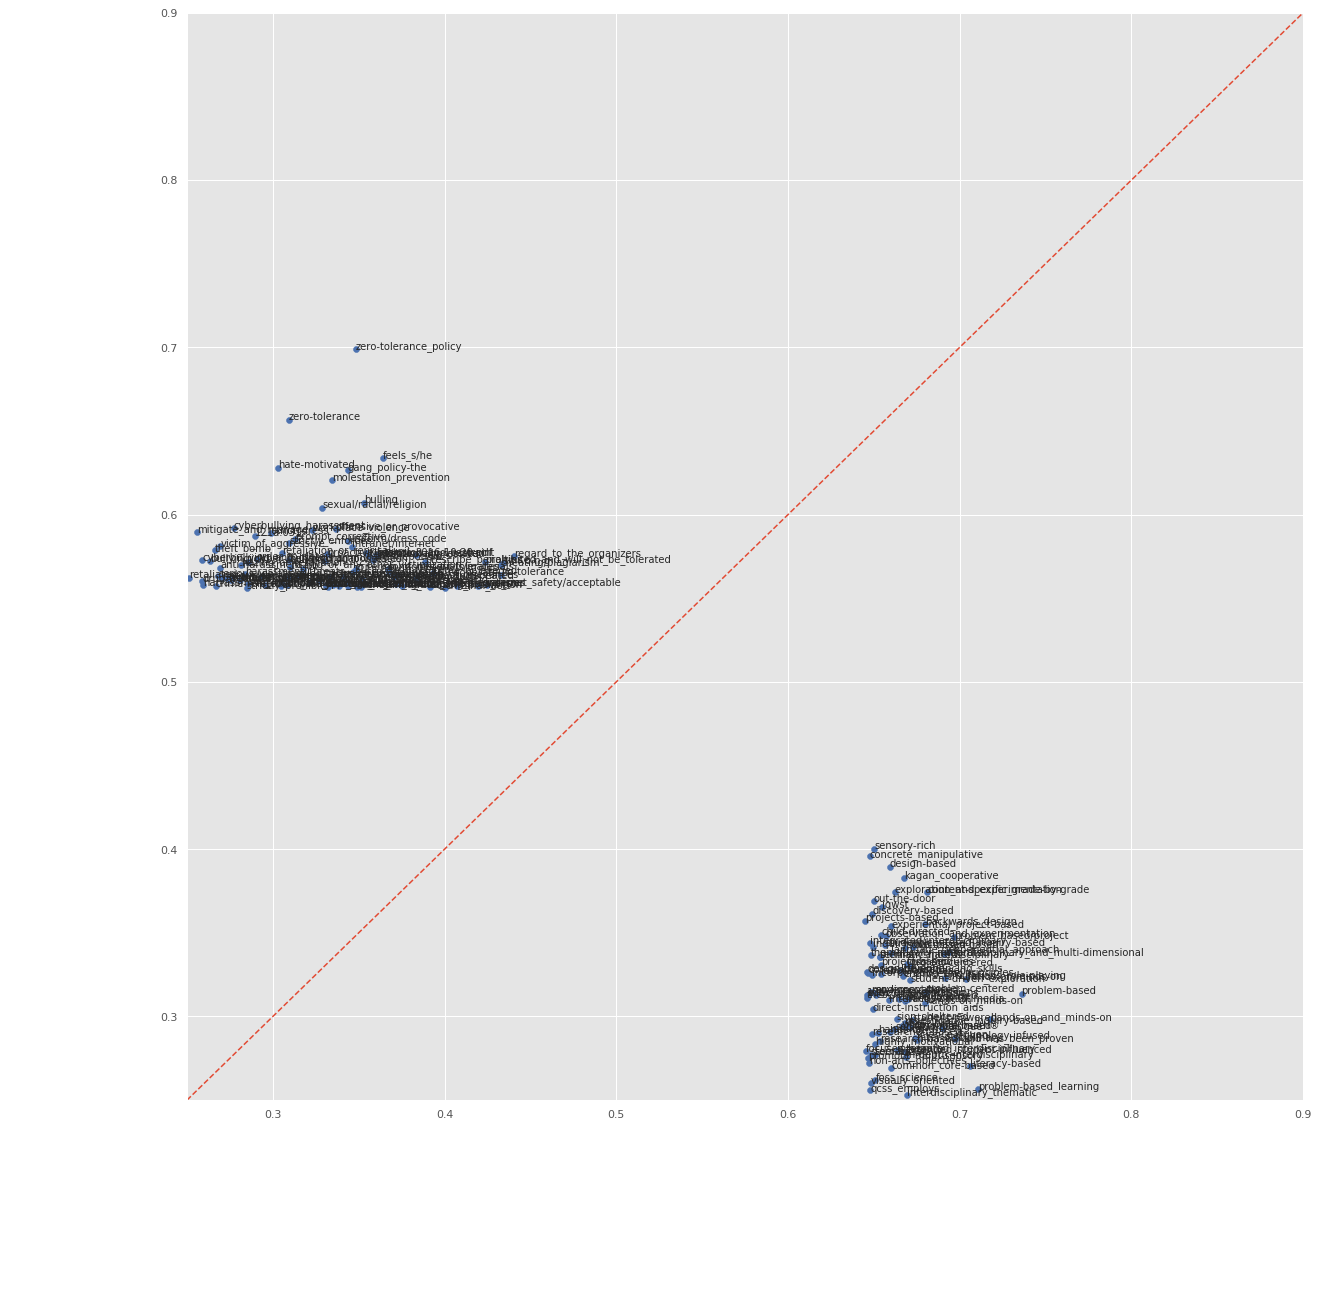

In [41]:
# here's a visual of the progressivism/essentialism binary: 
# top-left half is essentialism, bottom-right half is progressivism
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(phil_words)):
    ax.annotate(phil_words[i], (x[i], y[i]))
ax.set_xlim(0.25, .9)
ax.set_ylim(0.25, .9)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of essentialist (top-left) and progressivist (bottom-right) word vectors